<a href="https://www.kaggle.com/code/dsptlp/regression-with-timeline-data?scriptVersionId=168469291" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression based on Stock Market
- Using regression to predict next day price based on a large window of previous days data
- If you enable GPU the final model will use it

In [1]:
!pip install --upgrade pyarrow
!pip install GPUtil

# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import lightgbm as lgb
import GPUtil

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
import xgboost as xgb

warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

if len(gpus) > 0:
    print("GPU(s) available:")
    gpu_ready = 1
    for gpu in gpus:
        print(f"- {gpu.name}")
else:
    print("No GPU available.")
    gpu_ready = 0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 11.0.0
    Uninstalling pyarrow-11.0.0:
      Successfully uninstalled pyarrow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pya

## DEFINE FUNCTIONS

In [2]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [3]:
def load_data():

    # Reading the dataset
    dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

    try:
        # Attempt to read the dataset
        df = pd.read_csv(dataset_path)
        logger.info(f"Dataset loaded successfully from {dataset_path}")
    except FileNotFoundError:
        logger.error("Error: Dataset file not found. Please provide the correct file path.")
    except Exception as e:
        logger.error(f"An error occurred: {e}")

    # Rename the first column
    df = df.rename(columns={df.columns[0]: 'date_index'})

    df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price' , 'Google_Vol.', 'Nvidia_Price',
           'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
           'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
           'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'    ]]

    # Remove all commas
    df = df.replace(',','', regex=True)

    df['prev_index'] = df['date_index'] + 1
    
    return df    

In [4]:
def create_panel(window_back,df):
    for i in range (0,window_back,1):
        prev_df = get_prev_pane(df,i,'date_index')
        if i == 0:
            final_df = prev_df
        else:
            final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)

    final_df = final_df.iloc[:-window_back]
    return final_df    

In [5]:
def model_data(final_df):
    col_names = final_df.columns[1:].tolist()

    # creating a copy of df
    df1 = final_df.fillna(0)

    #target column name
    label_name = 'Natural_Gas_Price_0'

    # defining the features and target
    X = df1.drop([label_name],axis=1)
    y = df1[[label_name]]

    # instantiating the scaler
    scaler = RobustScaler()

    # scaling the continuous featuree
    X[col_names] = scaler.fit_transform(X[col_names])

    # Get centering and scaling values for each feature
    centering = scaler.center_
    iqrs  = scaler.scale_

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)    
    
    return X_train, X_test, y_train, y_test, centering, iqrs

# BASELINE MODELS

In [6]:
window_back = 2
df = load_data()   
final_df = create_panel(window_back,df)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test, centering, iqrs = model_data(final_df)

In [7]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror', n_jobs=-1),
    'SVR': SVR(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge()
}

AdaBoostRegressor CV Scores: [-0.08006085 -0.07215688 -0.04924933 -0.06509729 -0.05394642]
AdaBoostRegressor Mean Squared Error (MSE): 0.06894314309567319
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.2625702631595459
AdaBoostRegressor Mean Absolute Error (MAE): 0.18861709324873951
AdaBoostRegressor R^2 Score: 0.983452823192438


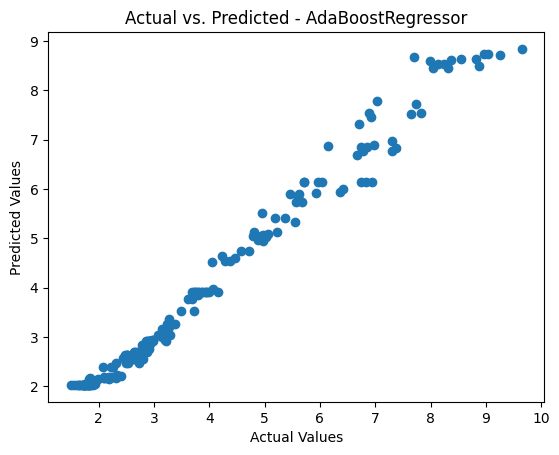

LinearRegression CV Scores: [-0.05274337 -0.05061002 -0.03322353 -0.05100098 -0.0353634 ]
LinearRegression Mean Squared Error (MSE): 0.04535164884025977
LinearRegression Root Mean Squared Error (RMSE): 0.21295926568304036
LinearRegression Mean Absolute Error (MAE): 0.14114233662655765
LinearRegression R^2 Score: 0.9891150632509915


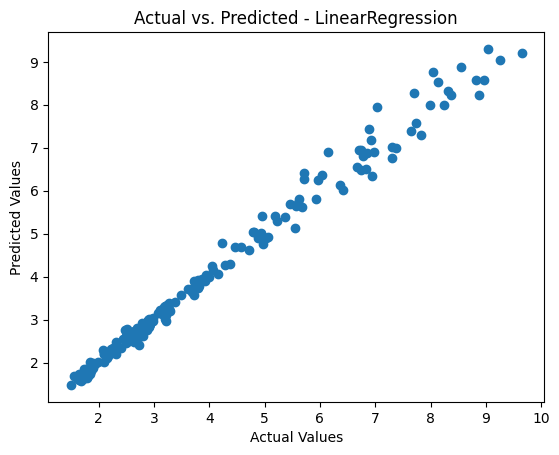

KNeighborsRegressor CV Scores: [-0.26346141 -0.28315597 -0.16613952 -0.24883125 -0.21461072]
KNeighborsRegressor Mean Squared Error (MSE): 0.2840220097029704
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.53293715361473
KNeighborsRegressor Mean Absolute Error (MAE): 0.337319801980198
KNeighborsRegressor R^2 Score: 0.9318313294003405


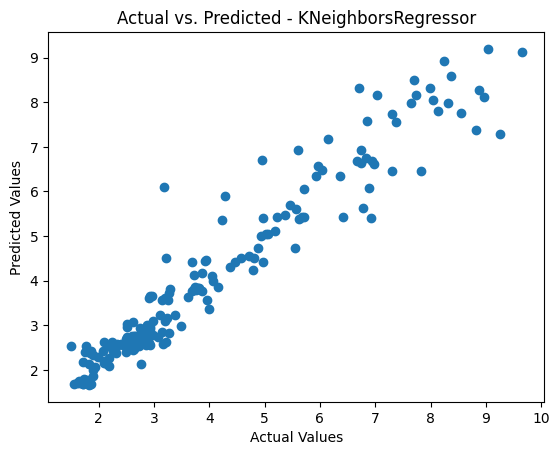

RandomForestRegressor CV Scores: [-0.06877182 -0.05581065 -0.03314629 -0.05664139 -0.04502789]
RandomForestRegressor Mean Squared Error (MSE): 0.0517372437054457
RandomForestRegressor Root Mean Squared Error (RMSE): 0.2274582240883932
RandomForestRegressor Mean Absolute Error (MAE): 0.1449836138613864
RandomForestRegressor R^2 Score: 0.98758244430571


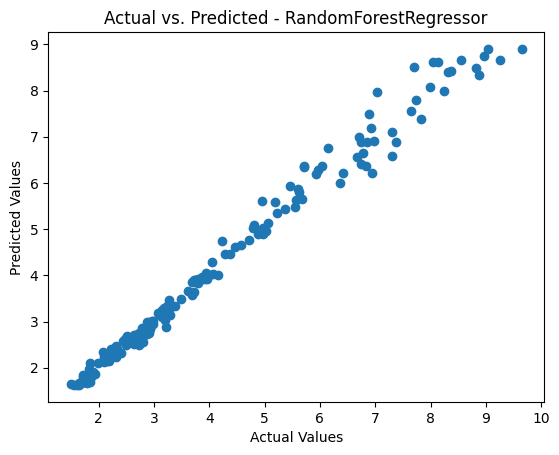

GradientBoostingRegressor CV Scores: [-0.17264466 -0.1405391  -0.13143785 -0.10513368 -0.11300146]
GradientBoostingRegressor Mean Squared Error (MSE): 0.1263772893046536
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.3554958358471356
GradientBoostingRegressor Mean Absolute Error (MAE): 0.25305106617333656
GradientBoostingRegressor R^2 Score: 0.9696679429354917


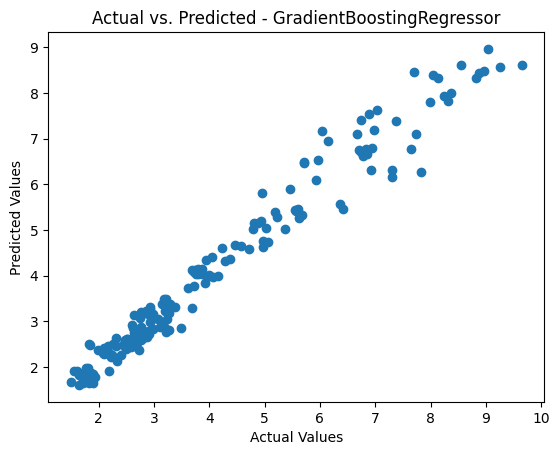

XGBRegressor CV Scores: [-0.08308862 -0.05576426 -0.0371557  -0.06262148 -0.06187395]
XGBRegressor Mean Squared Error (MSE): 0.06074799278048069
XGBRegressor Root Mean Squared Error (RMSE): 0.2464710789940286
XGBRegressor Mean Absolute Error (MAE): 0.15806942561121268
XGBRegressor R^2 Score: 0.9854197570330065


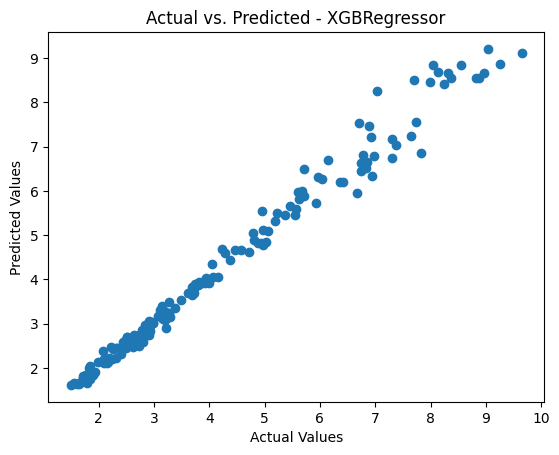

SVR CV Scores: [-0.16761621 -0.3263261  -0.15607272 -0.31055012 -0.26087781]
SVR Mean Squared Error (MSE): 0.1372960205438039
SVR Root Mean Squared Error (RMSE): 0.3705347764296948
SVR Mean Absolute Error (MAE): 0.25008809082254874
SVR R^2 Score: 0.9670473171819234


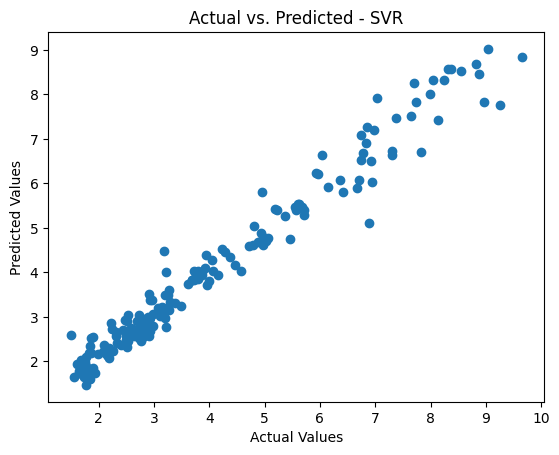

DecisionTreeRegressor CV Scores: [-0.10260169 -0.08139123 -0.09586704 -0.08622646 -0.092536  ]
DecisionTreeRegressor Mean Squared Error (MSE): 0.07918853465346534
DecisionTreeRegressor Root Mean Squared Error (RMSE): 0.28140457468467944
DecisionTreeRegressor Mean Absolute Error (MAE): 0.18602970297029706
DecisionTreeRegressor R^2 Score: 0.9809938069950733


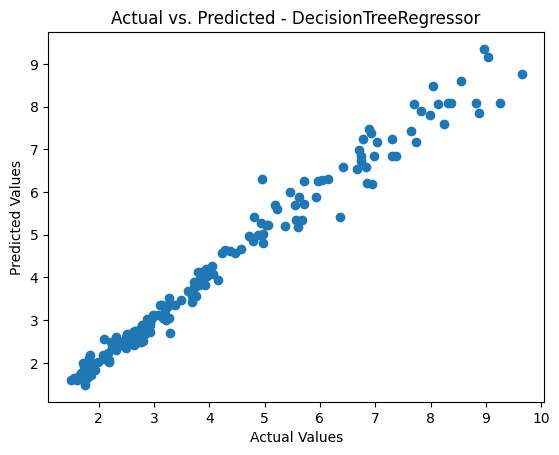

Lasso CV Scores: [-1.54999817 -2.03775498 -1.31523336 -1.45250987 -1.51715177]
Lasso Mean Squared Error (MSE): 1.76717915562183
Lasso Root Mean Squared Error (RMSE): 1.329352908606977
Lasso Mean Absolute Error (MAE): 1.0535981851644436
Lasso R^2 Score: 0.5758559208979885


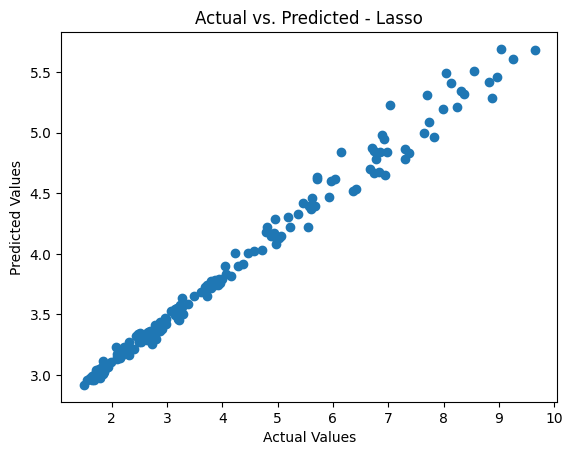

ElasticNet CV Scores: [-1.32253921 -1.67394222 -1.1395156  -1.21676906 -1.29601118]
ElasticNet Mean Squared Error (MSE): 1.4995246317241158
ElasticNet Root Mean Squared Error (RMSE): 1.2245507877275306
ElasticNet Mean Absolute Error (MAE): 0.9659595072320933
ElasticNet R^2 Score: 0.6400961996467138


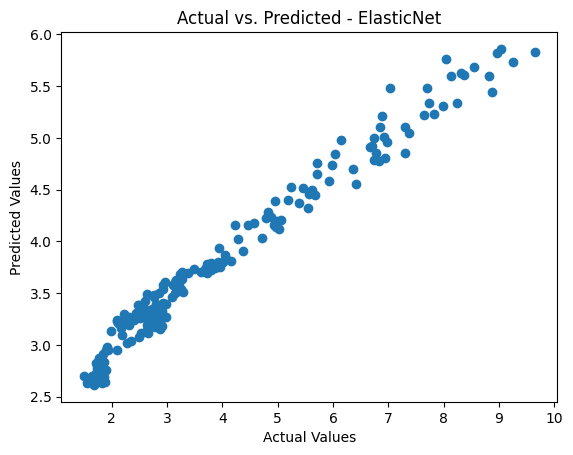

BayesianRidge CV Scores: [-0.05273495 -0.05069935 -0.03288374 -0.04939899 -0.03502589]
BayesianRidge Mean Squared Error (MSE): 0.04522667311324794
BayesianRidge Root Mean Squared Error (RMSE): 0.2126656368886331
BayesianRidge Mean Absolute Error (MAE): 0.14004241258799593
BayesianRidge R^2 Score: 0.9891450589163857


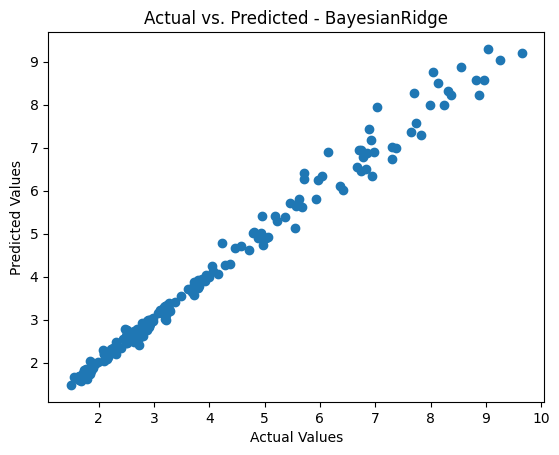

In [8]:
# Create a directory to save the plots if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.savefig(os.path.join("plots", f'Actual_vs_Predicted_{name}.png'))  # Save plot with the algorithm name appended
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


## Model Results Baseline
- MSE is the one that we will use as MSE penalizes larger errors more heavily, which can be important in financial forecasting where large errors may have significant consequences.

In [9]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.068943,0.262570,0.188617,0.983453,"[-0.08006084854589025, -0.0721568833680387, -0..."
1,LinearRegression,0.045352,0.212959,0.141142,0.989115,"[-0.05274337417864865, -0.05061002202978325, -..."
2,KNeighborsRegressor,0.284022,0.532937,0.337320,0.931831,"[-0.2634614135802469, -0.2831559681481482, -0...."
3,RandomForestRegressor,0.051737,0.227458,0.144984,0.987582,"[-0.06877181625679038, -0.055810650370370384, ..."
4,GradientBoostingRegressor,0.126377,0.355496,0.253051,0.969668,"[-0.17264465653632272, -0.1405390952736325, -0..."
5,XGBRegressor,0.060748,0.246471,0.158069,0.985420,"[-0.08308861623439583, -0.05576425586931316, -..."
6,SVR,0.137296,0.370535,0.250088,0.967047,"[-0.16761621120164696, -0.32632609783863525, -..."
7,DecisionTreeRegressor,0.079189,0.281405,0.186030,0.980994,"[-0.10260169135802466, -0.08139122839506176, -..."
8,Lasso,1.767179,1.329353,1.053598,0.575856,"[-1.5499981739122153, -2.0377549753908637, -1...."
9,ElasticNet,1.499525,1.224551,0.965960,0.640096,"[-1.3225392142516825, -1.673942215626732, -1.1..."


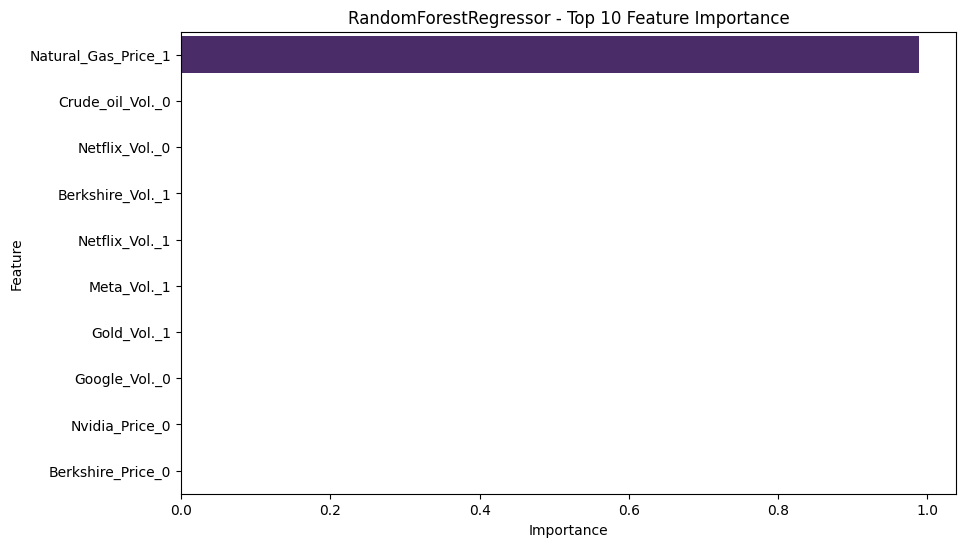

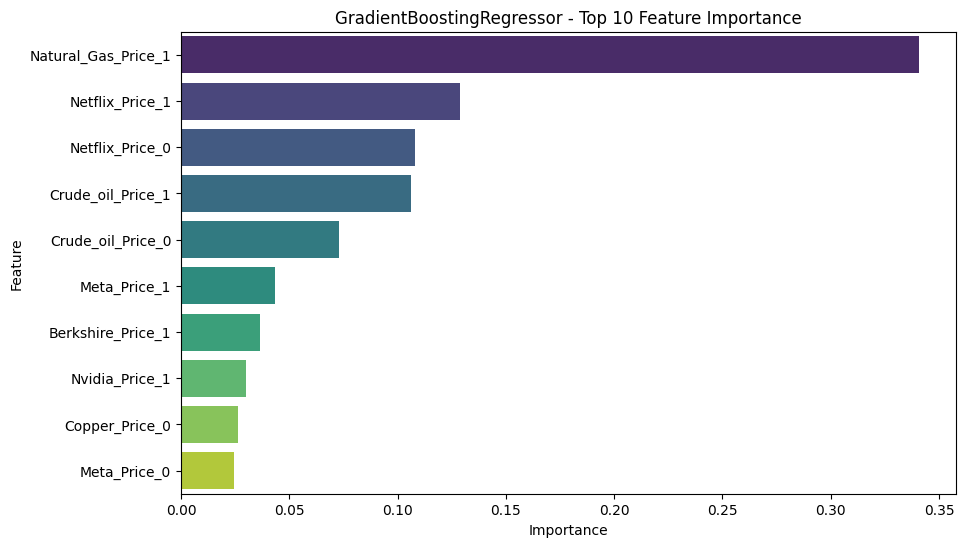

In [10]:
# Feature importance for tree-based models
for name, model in regressors.items():
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display only the top 10 features
        top_10_features = sorted_df.head(10)
        
        # Create seaborn bar plot for the top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
        plt.title(f"{name} - Top 10 Feature Importance")
        plt.show()


## FINAL MODEL - LightGBM
- Define Parameter Grid: Specify the grid of hyperparameters you want to search over.
- Check GPU Availability: Determine whether to use GPU or CPU based on availability.
- Create LightGBM Model: Instantiate a LightGBM regressor model.
- Perform GridSearchCV: Use GridSearchCV to search over the hyperparameter grid and find the best combination of hyperparameters.
- Display Results: Display the results for each parameter combination.
- Get Best Parameters: Retrieve the best hyperparameters from the grid search.
- Train Final Model: Train the final LightGBM model using the best hyperparameters.
- Make Predictions: Make predictions on the test set using the final model.
- Evaluate Model: Evaluate the performance of the final model using evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R^2 Score.
- Store Results: Store the evaluation results for future reference.

In [11]:
window_back = 20
df = load_data()   
final_df = create_panel(window_back,df)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test, centering, iqrs = model_data(final_df)

In [12]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [50,100,300],
    'objective': ['regression'],
    'metric': ['mse'],
    'boosting_type': ['gbdt'],
    'is_enable_sparse': ['true'],        
    'max_drop': [1,10],       
    'learning_rate': [0.01,0.1],
    'feature_fraction': [1],
    'min_child_samples': [10,20,100],
    'min_child_weight': [1e-5,1e-4,1e-3],
    'max_depth': [-1],
    'num_iterations': [1000,2000,10000],
    'max_bin': [200],
    'subsample': [1],
    'colsample_bytree': [1],
    'reg_alpha': [0.0,0.01],
    'reg_lambda': [0,0.01],
    'gpu_use_dp': ['true'],
    'verbosity': [-1]
}

callbacks = [lgb.log_evaluation(50),lgb.early_stopping(10)]
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

if gpu_ready == 1:    
    param_grid['device'] = ['gpu']
    print("USING GPU")
else:    
    param_grid['device']  = ['cpu']
    print("USING CPU")
    
# Create a LightGBM model
lgb_model = lgb.LGBMRegressor(verbose=-1)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='mse',
                 callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)])

# Display results for each parameter combination
results_df = pd.DataFrame(grid_search.cv_results_)
print("Grid Search Results:")
print(results_df[['params', 'mean_test_score', 'rank_test_score']])
print(results_df)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

# Make predictions on the test set
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration_)

# Evaluation metrics for regression
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=============================================================================")
print(name, "CV Scores:", cv_scores)
print(name, "Mean Squared Error (MSE):", mse)
print(name, "Root Mean Squared Error (RMSE):", rmse)
print(name, "Mean Absolute Error (MAE):", mae)
print(name, "R^2 Score:", r2)

model_results.append({'Model': 'Final_Model', 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': [0]})

USING GPU


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
111 warning warning warning generated generated generated.
.
.
1 warning generated.
1 warning generated.
1 warning g

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33693
[100]	valid_0's l2: 0.524433
[150]	valid_0's l2: 0.227074
[200]	valid_0's l2: 0.123758
[250]	valid_0's l2: 0.0906393
[300]	valid_0's l2: 0.0812068
[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31729
[100]	valid_0's l2: 0.516253
[150]	valid_0's l2: 0.21763
[200]	valid_0's l2: 0.110722
[250]	valid_0's l2: 0.0731225
[300]	valid_0's l2: 0.0603083
[350]	valid_0's l2: 0.0562304
[400]	valid_0's l2: 0.0551862
Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, b

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	valid_0's l2: 0.0688899
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0's l2: 0.0808437
[350]	valid_0's l2: 0.0786237
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0785039
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33797
[100]	valid_0's l2: 0.524661
[150]	valid_0's l2: 0.227298
[200]	valid_0's l2: 0.123557
[250]	valid_0's l2: 0.0906947
[300]	valid_0's l2: 0.0810662
[350]	valid_0's l2: 0.078737
Early stopping, best iteration is:
[358]	valid_0's l2: 0.0785566
Training unti

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.29956
[100]	valid_0's l2: 0.491461
[150]	valid_0's l2: 0.205771
[200]	valid_0's l2: 0.109419
[250]	valid_0's l2: 0.0791886
[300]	valid_0's l2: 0.0705948
[350]	valid_0's l2: 0.0683889
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0682326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31632
[100]	valid_0's l2: 0.514804
[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid_0's l2: 0.494209
[150]	valid_0's l2: 0.20721
[200]	valid_0's l2: 0.1101
[250]	valid_0's l2: 0.079764
[300]	valid_0's l2: 0.0705689
Early stopping, best iteration is:
[339]	valid_0's l2: 0.0681502
Training until 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid_0's l2: 0.494209
[150]	valid_0's l2: 0.20721
[200]	valid_0's l2: 0.1101
[250]	valid_0's l2: 0.079764
[300]	valid_0's l2: 0.0705689
Early stopping, best iteration is:
[339]	valid_0's l2: 0.0681502
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33693
[100]	valid_0's l2: 0.524433
[150]	valid_0's l2: 0.227074
[200]	valid_0's l2: 0.123758
[250]	valid_0's l2: 0.0906393
[300]	valid_0's l2: 0.0812068
[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33797
[100]	valid_0's l2: 0.524661
[150]	valid_0's l2: 0.227298
[200]	valid_0's l2: 0.123557
[250]	valid_0's l2: 0.0906947
[300]	valid_0's l2: 0.0810662
[350]	valid_0's l2: 0.078737
Early stopping, best iteration is:
[358]	valid_0's l2: 0.0785566
Training until validation scores don't improv

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	valid_0's l2: 0.0688899
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, be

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid_0's l2: 0.494209
[150]	valid_0's l2: 0.20721
[200]	valid_0's l2: 0.1101
[250]	valid_0's l2: 0.079764
[300]	valid_0's l2: 0.0705689
Early stopping, best iteration is:
[339]	valid_0's l2: 0.0681502
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31632
[100]	valid_0's l2: 0.514804
[150]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0's l2: 0.0808437
[350]	valid_0's l2: 0.0786237
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0785039
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31729
[100]	valid_0's l2: 0.516253
[150]	valid_0's l2: 0.21763
[200]	valid_0's l2: 0.110722
[250]	valid_0's l2: 0.0731225
[300]	valid_0's l2: 0.0603083
[350]	valid_0's l2: 0.0562304
[400]	valid_0's l2: 0.0551862
Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.524661
[150]	valid_0's l2: 0.227298
[200]	valid_0's l2: 0.123557
[250]	valid_0's l2: 0.0906947
[300]	valid_0's l2: 0.0810662
[350]	valid_0's l2: 0.078737
Early stopping, best iteration is:
[358]	valid_0's l2: 0.0785566
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	valid_0's l2: 0.0688899
Training until validation scores don't improve for 10 rounds
[50]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, best iteration is:
[439]	valid_0's l2: 0.0551924
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33693
[100]	valid_0's l2: 0.524433
[150]	valid_0's l2: 0.227074
[200]	valid_0's l2: 0.123758
[250]	valid_0's l2: 0.0906393
[300]	valid_0's l2: 0.0812068
[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31729
[100]	valid_0's l2: 0.516253
[150]	valid_0's l2: 0.21763
[200]	valid_0's l2: 0.110722
[250]	valid_0's l2: 0.0731225
[300]	valid_0's l2: 0.0603083
[350]	valid_0's l2: 0.0562304
[400]	valid_0's l2: 0.0551862
Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't i

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[362]	valid_0's l2: 0.0785039
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33797
[100]	valid_0's l2: 0.524661
[150]	valid_0's l2: 0.227298
[200]	valid_0's l2: 0.123557
[250]	valid_0's l2: 0.0906947
[300]	valid_0's l2: 0.0810662
[350]	valid_0's l2: 0.078737
Early stopping, best iteration is:
[358]	valid_0's l2: 0.0785566
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31632
[100]	valid_0's l2: 0.514804
[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0's l2: 0.0808437
[350]	valid_0's l2: 0.0786237
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0785039
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid_0's l2: 0.494209
[150]	valid_0's l2: 0.20721
[200]	valid_0's l2: 0.1101
[250]	valid_0's l2: 0.079764
[300]	valid_0's l2: 0.0705689
Early stopping, best iteration is:
[339]	valid_0's l2: 0.0681502
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.29956
[100]	valid_0's l2: 0.491461
[150]	valid_0's l2: 0.205771
[200]	valid_0's l2: 0.109419
[250]	valid_0's l2: 0.0791886
[300]	valid_0's l2: 0.0705948
[350]	valid_0's l2: 0.0683889
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0682326
Training until validation scores don't improv

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid_0's l2: 0.494209
[150]	valid_0's l2: 0.20721
[200]	valid_0's l2: 0.1101
[250]	valid_0's l2: 0.079764
[300]	valid_0's l2: 0.0705689
Early stopping, best iteration is:
[339]	valid_0's l2: 0.0681502
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.29956
[100]	valid_0's l2: 0.491461
[150]	valid_0's l2: 0.205771
[200]	valid_0's l2: 0.109419
[250]	valid_0's l2: 0.0791886
[300]	valid_0's l2: 0.0705948
[350]	valid_0's l2: 0.0683889
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0682326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0's l2: 0.0808437
[350]	valid_0's l2: 0.0786237
Early stopping, best iteration is:
[362]	vali

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	valid_0's l2: 0.0688899
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	valid_0's l2: 0.0810662
[350]	valid_0's l2: 0.078737
Early stopping, best iteration is:
[358]	valid_0's l2: 0.0785566
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31632
[100]	valid_0's l2: 0.514804
[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[350]	valid_0's l2: 0.0784511
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0781836
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32444
[100]	valid_0's l2: 0.503516
[150]	valid_0's l2: 0.208714
[200]	valid_0's l2: 0.105681
[250]	valid_0's l2: 0.0713897
[300]	valid_0's l2: 0.0601567
[350]	valid_0's l2: 0.0572672
[400]	valid_0's l2: 0.056299
[450]	valid_0's l2: 0.05584
Early stopping, best iteration is:
[446]	valid_0's l2: 0.0557075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33587
[100]	valid_0's l2: 0.518807
[150]	valid_0's l2: 0.228136
[200]	valid_0's l2: 0.127689
[250]	valid_0's l2: 0.0945931
[300]	valid_0's l2: 0.082422
[350]	valid_0's l2: 0.0790162
Early stopping, best iteration is:
[384]	valid_0's l2: 0.0784938
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32437
[100]	valid_0's l2: 0.504012
[150]	valid_0's l2: 0.209445
[200]	valid_0's l2: 0.10591
[250]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.0709912
[300]	valid_0's l2: 0.0597094
[350]	valid_0's l2: 0.0566265
[400]	valid_0's l2: 0.055765
Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31703
[100]	valid_0's l2: 0.499772
[150]	valid_0's l2: 0.209556
[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32444
[100]	valid_0's l2: 0.503516
[150]	valid_0's l2: 0.208714
[200]	valid_0's l2: 0.105681
[250]	valid_0's l2: 0.0713897
[300]	valid_0's l2: 0.0601567
[350]	valid_0's l2: 0.0572672
[400]	valid_0's l2: 0.056299
[450]	valid_0's l2: 0.05584
Early stopping, best iteration is:
[446]	valid_0's l2: 0.0557075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32475
[100]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[400]	valid_0's l2: 0.055765
Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33547
[100]	valid_0's l2: 0.518996
[150]	valid_0's l2: 0.22877
[200]	valid_0's l2: 0.128268
[250]	valid_0's l2: 0.094576
[300]	valid_0's l2: 0.0826041
[350]	valid_0's l2: 0.0792127
Early stopping, best iteration is:
[382]	valid_0's l2: 0.0787735
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32501
[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0's l2: 0.0602106
[350]	valid_0's l2: 0.0569011
[400]	valid_0's l2: 0.0561194
Early stopping, best iteration is:
[420]	valid_0's l2: 0.0557712
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31657
[100]	valid_0's l2: 0.499507
[150]	valid_0's l2: 0.208733
[200]	valid_0's l2: 0.112067
[250]	valid_0's l2: 0.0783908
[300]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[50]	valid_0's l2: 1.33547
[100]	valid_0's l2: 0.518996
[150]	valid_0's l2: 0.22877
[200]	valid_0's l2: 0.128268
[250]	valid_0's l2: 0.094576
[300]	valid_0's l2: 0.0826041
[350]	valid_0's l2: 0.0792127
Early stopping, best iteration is:
[382]	valid_0's l2: 0.0787735
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32501
[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0's l2: 0.0602106
[350]	valid_0's l2: 0.0569011
[400]	valid_0's l2: 0.0561194
Early stopping, best iteration is:
[420]	valid_0's l2: 0.0557712
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31657
[100]	valid_0's l2: 0.499507
[150]	valid_0's l2: 0.208733
[200]	valid_0's l2: 0.112067
[250]	valid_0's l2: 0.0783908
[300]	valid_0's l2: 0.0679235
Early stopping, best iteration is:
[329]	valid_0's l2: 0.0665629
Training until validation scores don't improve for 10 rounds
[50]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 


Early stopping, best iteration is:
[334]	valid_0's l2: 0.066347
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33587
[100]	valid_0's l2: 0.518807
[150]	valid_0's l2: 0.228136
[200]	valid_0's l2: 0.127689
[250]	valid_0's l2: 0.0945931
[300]	valid_0's l2: 0.082422
[350]	valid_0's l2: 0.0790162
Early stopping, best iteration is:
[384]	valid_0's l2: 0.0784938
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32437
[100]	valid_0's l2: 0.504012
[150]	valid_0's l2: 0.209445
[200]	valid_0's l2: 0.10591
[250]	valid_0's l2: 0.0713398
[300]	valid_0's l2: 0.0602059
[350]	valid_0's l2: 0.0569693
[400]	valid_0's l2: 0.0561417
[450]	valid_0's l2: 0.0554614
Early stopping, best iteration is:
[451]	valid_0's l2: 0.0554522
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32501
[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32444
[100]	valid_0's l2: 0.503516
[150]	valid_0's l2: 0.208714
[200]	valid_0's l2: 0.105681
[250]	valid_0's l2: 0.0713897
[300]	valid_0's l2: 0.0601567
[350]	valid_0's l2: 0.0572672
[400]	valid_0's l2: 0.056299
[450]	valid_0's l2: 0.05584
Early stopping, best iteration is:
[446]	valid_0's l2: 0.0557075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33587
[100]	valid_0's l2: 0.518807
[150]	valid_0's l2: 0.228136
[200]	valid_0's l2: 0.127689
[250]	valid_0's l2: 0.0945931
[300]	valid_0's l2: 0.082422
[350]	valid_0's l2: 0.0790162
Early stopping, best iteration is:
[384]	valid_0's l2: 0.0784938
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33582
[100]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	valid_0's l2: 0.518891
[150]	valid_0's l2: 0.228225
[200]	valid_0's l2: 0.127702
[250]	valid_0's l2: 0.0942239
[300]	valid_0's l2: 0.0826559
[350]	valid_0's l2: 0.0788632
Early stopping, best iteration is:
[372]	valid_0's l2: 0.0784917
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32475
[100]	valid_0's l2: 0.503725
[150]	valid_0's l2: 0.209138
[200]	valid_0's l2: 0.105442
[250]	valid_0's l2: 0.0709912
[300]	valid_0's l2: 0.0597094
[350]	valid_0's l2: 0.0566265
[400]	valid_0's l2: 0.055765
Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33547
[100]	valid_0's l2: 0.518996
[150]	valid_0's l2: 0.22877
[200]	valid_0's l2: 0.128268
[250]	valid_0's l2: 0.094576
[300]	valid_0's l2: 0.0826041
[350]	valid_0's l2: 0.0792127
Early stopping, best iteration is:
[382]	valid_0's l2: 0.0787735
Training until validation scores don't improve for 10 rounds
[50]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31645
[100]	valid_0's l2: 0.499384
[150]	valid_0's l2: 0.208846
[200]	valid_0's l2: 0.111904
[250]	valid_0's l2: 0.0780682
[300]	valid_0's l2: 0.0676779
Early stopping, best iteration is:
[334]	valid_0's l2: 0.066347
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31671
[100]	valid_0's l2: 0.499542
[150]	valid_0's l2: 0.208801
[200]	valid_0's l2: 0.111133
[250]	valid_0's l2: 0.077904
[300]	valid_0's l2: 0.0672376
[350]	valid_0's l2: 0.0658295
Early stopping, best iteration is:
[345]	valid_0's l2: 0.0657115
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32437
[100]	valid_0's l2: 0.504012
[150]	valid_0's l2: 0.209445
[200]	valid_0's l2: 0.10591
[250]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[50]	valid_0's l2: 1.32437
[100]	valid_0's l2: 0.504012
[150]	valid_0's l2: 0.209445
[200]	valid_0's l2: 0.10591
[250]	valid_0's l2: 0.0713398
[300]	valid_0's l2: 0.0602059
[350]	valid_0's l2: 0.0569693
[400]	valid_0's l2: 0.0561417
[450]	valid_0's l2: 0.0554614
Early stopping, best iteration is:
[451]	valid_0's l2: 0.0554522
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.3352
[100]	valid_0's l2: 0.518891
[150]	valid_0's l2: 0.228225
[200]	valid_0's l2: 0.127702
[250]	valid_0's l2: 0.0942239
[300]	valid_0's l2: 0.0826559
[350]	valid_0's l2: 0.0788632
Early stopping, best iteration is:
[372]	valid_0's l2: 0.0784917
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33587
[100]	valid_0's l2: 0.518807
[150]	valid_0's l2: 0.228136
[200]	valid_0's l2: 0.127689
[250]	valid_0's l2: 0.0945931
[300]	valid_0's l2: 0.082422
[350]	valid_0's l2: 0.0790162
Early stopping, best iteration is:
[384]	valid_0's l2: 0.0784938
Training until

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33582
[100]	valid_0's l2: 0.519418
[150]	valid_0's l2: 0.228335
[200]	valid_0's l2: 0.12751
[250]	valid_0's l2: 0.0941767
[300]	valid_0's l2: 0.0819652
[350]	valid_0's l2: 0.0784511
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0781836
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33547
[100]	valid_0's l2: 0.518996
[150]	valid_0's l2: 0.22877
[200]	valid_0's l2: 0.128268
[250]	valid_0's l2: 0.094576
[300]	valid_0's l2: 0.0826041
[350]	valid_0's l2: 0.0792127
Early stopping, best iteration is:
[382]	valid_0's l2: 0.0787735
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32501
[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0's l2: 0.0602106
[350]	valid_0's l2: 0.0569011
[400]	valid_0's l2: 0.0561194
Early stopping, best iteration is:
[420]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[400]	valid_0's l2: 0.0561417
[450]	valid_0's l2: 0.0554614
Early stopping, best iteration is:
[451]	valid_0's l2: 0.0554522
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32501
[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0's l2: 0.0602106
[350]	valid_0's l2: 0.0569011
[400]	valid_0's l2: 0.0561194
Early stopping, best iteration is:
[420]	valid_0's l2: 0.0557712
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32475
[100]	valid_0's l2: 0.503725
[150]	valid_0's l2: 0.209138
[200]	valid_0's l2: 0.105442
[250]	valid_0's l2: 0.0709912
[300]	valid_0's l2: 0.0597094
[350]	valid_0's l2: 0.0566265
[400]	valid_0's l2: 0.055765
Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31703
[100]	valid_0's l2: 0.499772
[150]	valid_0's l2: 0.209556
[200]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[700]	valid_0's l2: 0.166002
[750]	valid_0's l2: 0.161256
[800]	valid_0's l2: 0.157646
[850]	valid_0's l2: 0.154461
[900]	valid_0's l2: 0.151152
[950]	valid_0's l2: 0.148438
[1000]	valid_0's l2: 0.145911
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.145911


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[350]	valid_0's l2: 0.205647
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195701
[500]	valid_0's l2: 0.187019
[550]	valid_0's l2: 0.179693
[600]	valid_0's l2: 0.174025
[650]	valid_0's l2: 0.168306
[700]	valid_0's l2: 0.163886
[750]	valid_0's l2: 0.159449
[800]	valid_0's l2: 0.155779
[850]	valid_0's l2: 0.152325
[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.143327
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201608
[450]	valid_0's l2: 0.195564
[500]	valid_0's l2: 0.18714
[550]	valid_0's l2: 0.179777
[600]	valid_0's l2: 0.17401
[650]	valid_0's l2: 0.168503
[700]	valid_0's l2: 0.163758
[750]	valid_0's l2: 0.15976
[800]	valid_0's l2: 0.15584

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[750]	valid_0's l2: 0.180612
[800]	valid_0's l2: 0.176019
[850]	valid_0's l2: 0.171772
[900]	valid_0's l2: 0.167901
[950]	valid_0's l2: 0.164038
[1000]	valid_0's l2: 0.160436
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160436
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	valid_0's l2: 0.247636
[350]	valid_0's l2: 0.234651
[400]	valid_0's l2: 0.224824
[450]	valid_0's l2: 0.215422
[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160721
Training until validation scores

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.145998
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44496
[100]	valid_0's l2: 0.648414
[150]	valid_0's l2: 0.367339
[200]	valid_0's l2: 0.267145
[250]	valid_0's l2: 0.227053
[300]	valid_0's l2: 0.212474
[350]	valid_0's l2: 0.208609
[400]	valid_0's l2: 0.206023
[450]	valid_0's l2: 0.200208
[500]	valid_0's l2: 0.192983
[550]	valid_0's l2: 0.185734
[600]	valid_0's l2: 0.177683
[650]	valid_0's l2: 0.171489
[700]	valid_0's l2: 0.166002
[750]	valid_0's l2: 0.161256
[800]	valid_0's l2: 0.157646
[850]	valid_0's l2: 0.154461
[900]	valid_0's l2: 0.151152
[950]	valid_0's l2: 0.1484

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160194
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1200]	valid_0's l2: 0.138065
[1250]	valid_0's l2: 0.136088
[1300]	valid_0's l2: 0.134057
[1350]	valid_0's l2: 0.132357
[1400]	valid_0's l2: 0.131086
Early stopping, best iteration is:
[1390]	valid_0's l2: 0.131073
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.14856

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1300]	valid_0's l2: 0.147027
[1350]	valid_0's l2: 0.145184
[1400]	valid_0's l2: 0.143587
[1450]	valid_0's l2: 0.14206
[1500]	valid_0's l2: 0.140544
[1550]	valid_0's l2: 0.13944
[1600]	valid_0's l2: 0.138308
[1650]	valid_0's l2: 0.137414
[1700]	valid_0's l2: 0.136641
[1750]	valid_0's l2: 0.135921
[1800]	valid_0's l2: 0.135108
[1850]	valid_0's l2: 0.134114
[1900]	valid_0's l2: 0.133319
[1950]	valid_0's l2: 0.132472
[2000]	valid_0's l2: 0.131782
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131782
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	valid_0's l2: 0.247636
[350]	valid_0's l2: 0.234651
[400]	valid_0's l2: 0.224824
[450]	valid_0's l2: 0.215422
[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1400]	valid_0's l2: 0.143587
[1450]	valid_0's l2: 0.14206
[1500]	valid_0's l2: 0.140544
[1550]	valid_0's l2: 0.13944
[1600]	valid_0's l2: 0.138308
[1650]	valid_0's l2: 0.137414
[1700]	valid_0's l2: 0.136641
[1750]	valid_0's l2: 0.135921
[1800]	valid_0's l2: 0.135108
[1850]	valid_0's l2: 0.134114
[1900]	valid_0's l2: 0.133319
[1950]	valid_0's l2: 0.132472
[2000]	valid_0's l2: 0.131782
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131782
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	valid_0's l2: 0.247636
[350]	valid_0's l2: 0.234651
[400]	valid_0's l2: 0.224824
[450]	valid_0's l2: 0.215422
[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0's l2: 0.141412
[1500]	valid_0's l2: 0.139934
[1550]	valid_0's l2: 0.138783
[1600]	valid_0's l2: 0.137798
[16

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44507
[100]	valid_0's l2: 0.648495
[150]	valid_0's l2: 0.367384
[200]	valid_0's l2: 0.267166
[250]	valid_0's l2: 0.227061
[300]	valid_0's l2: 0.212477
[350]	valid_0's l2: 0.208444
[400]	valid_0's l2: 0.205816
[450]	valid_0's l2: 0.200082
[500]	valid_0's l2: 0.19283
[550]	valid_0's l2: 0.185751
[600]	valid_0's l2: 0.178057
[650]	valid_0's l2: 0.17122
[700]	valid_0's l2: 0.165719
[750]	valid_0's l2: 0.161279
[800]	valid_0's l2: 0.157565
[850]	valid_0's l2: 0.154202
[900]	valid_0's l2: 0.151012
[950]	valid_0's l2: 0.148327
[1000]	valid_0's l2: 0.145844
[1050]	valid_0's l2: 0.143607
[1100]	valid_0's l2: 0.141577
[1150]	valid_0's l2: 0.139519
[1200]	valid_0's l2: 0.137425
[1250]	valid_0's l2: 0.135545
[1300]	valid_0's l2: 0.133491
[1350]	valid_0's l2: 0.131904
[1400]	valid_0's l2: 0.130696
[1450]	valid_0's l2: 0.129518
[1500]	valid_0's l2: 0.12827
[1550]	valid_0's l2: 0.127035
[1600]	valid_0's l2: 0.125669
[16

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195701
[500]	valid_0's l2: 0.187019
[550]	valid_0's l2: 0.179693
[600]	valid_0's l2: 0.174025
[650]	valid_0's l2: 0.168306
[700]	valid_0's l2: 0.163886
[750]	valid_0's l2: 0.159449
[800]	valid_0's l2: 0.155779
[850]	valid_0's l2: 0.152325
[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0.131516
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201608
[450]	valid_0's l2: 0.195564
[

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
[1050]	valid_0's l2: 0.157816
[1100]	valid_0's l2: 0.155622
[1150]	valid_0's l2: 0.153605
[1200]	valid_0's l2: 0.151232
[1250]	valid_0's l2: 0.148868
[1300]	valid_0's l2: 0.146714
[1350]	valid_0's l2: 0.144904
[1400]	valid_0's l2: 0.143149
[1450]	valid_0's l2: 0.141603
[1500]	valid_0's l2: 0.140118
[1550]	valid_0's l2: 0.139122
[1600]	valid_0's l2: 0.138055
[1650]	valid_0's l2: 0.137157
[1700]	valid_0's l2: 0.13619
[1750]	valid_0's l2: 0.135508
[1800]	valid_0's l2: 0.13451
Early stopping, best iteration is:
[1831]	valid_0's l2: 0.133954
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44502
[100]	valid_0's l2: 0.648425
[150]	valid_0's l2: 0.

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1300]	valid_0's l2: 0.134159
Early stopping, best iteration is:
[1319]	valid_0's l2: 0.133506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55844
[100]	valid_0's l2: 0.765652
[150]	valid_0's l2: 0.458929
[200]	valid_0's l2: 0.331357
[250]	valid_0's l2: 0.273753
[300]	valid_0's l2: 0.247626
[350]	valid_0's l2: 0.234673
[400]	valid_0's l2: 0.225117
[450]	valid_0's l2: 0.215521
[500]	valid_0's l2: 0.208867
[550]	valid_0's l2: 0.202357
[600]	valid_0's l2: 0.196094
[650]	valid_0's l2: 0.189804
[700]	valid_0's l2: 0.185069
[750]	valid_0's l2: 0.180612
[800]	valid_0's l2: 0.176019
[850]	valid_0's l2: 0.171772
[900]	valid_0's l2: 0.167901
[950]	valid_0's l2: 0.164038
[1000]	valid_0's l2: 0.160436
[1050]	valid_0's l2: 0.157624
[1100]	valid_0's l2: 0.155553
[1150]	valid_0's l2: 0.153268
[1200]	valid_0's l2: 0.150876
[1250]	valid_0's l2: 0.148559
[1300]	valid_0's l2: 0.146603
[1350]	valid_0's l2: 0.144819
[1400]	valid_0's l2: 0.143186
[1450]	valid_0's l2: 0.14

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1950]	valid_0's l2: 0.119289
[2000]	valid_0's l2: 0.118538
[2050]	valid_0's l2: 0.117942
[2100]	valid_0's l2: 0.117394
[2150]	valid_0's l2: 0.116993
[2200]	valid_0's l2: 0.116364
Early stopping, best iteration is:
[2199]	valid_0's l2: 0.116364
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55889
[100]	valid_0's l2: 0.76605
[150]	valid_0's l2: 0.458783
[200]	valid_0's l2: 0.331516
[250]	valid_0's l2: 0.273942
[300]	valid_0's l2: 0.247984
[350]	valid_0's l2: 0.234956
[400]	valid_0's l2: 0.225378
[450]	valid_0's l2: 0.215776
[500]	valid_0's l2: 0.20922
[550]	valid_0's l2: 0.202575
[600]	valid_0's l2: 0.196124
[650]	valid_0's l2: 0.190567
[700]	valid_0's l2: 0.185278
[750]	valid_0's l2: 0.180862
[800]	valid_0's l2: 0.176181
[850]	valid_0's l2: 0.171671
[900]	valid_0's l2: 0.168094
[950]	valid_0's l2: 0.164343
[1000]	valid_0's l2: 0.160766
[1050]	valid_0's l2: 0.158104
[1100]	valid_0's l2: 0.155813
[1150]	valid_0's l2: 0.153691
[1200]	valid_0's l2: 0.1515

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	valid_0's l2: 0.247636
[350]	valid_0's l2: 0.234651
[400]	valid_0's l2: 0.224824
[450]	valid_0's l2: 0.215422
[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
[1050]	valid_0's l2: 0.157816
[1100]	valid_0's l2: 0.155622
[1150]	valid_0's l2: 0.153605
[1200]	valid_0's l2: 0.151232
[1250]	valid_0's l2: 0.148868
[1300]	valid_0's l2: 0.146714
[1350]	valid_0's l2: 0.144904
[1400]	valid_0's l2: 0.143149
[1450]	valid_0's l2: 0.141603
[1500]	valid_0's l2: 0.140118
[1550]	valid_0's l2: 0.139122
[1600]	valid_0's l2: 0.138055
[16

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.145844
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44502
[100]	valid_0's l2: 0.648425
[150]	valid_0's l2: 0.36741
[200]	valid_0's l2: 0.267299
[250]	valid_0's l2: 0.227263
[300]	valid_0's l2: 0.212681
[350]	valid_0's l2: 0.208676
[400]	valid_0's l2: 0.206061
[450]	valid_0's l2: 0.200387
[500]	valid_0's l2: 0.192685
[550]	valid_0's l2: 0.185555
[600]	valid_0's l2: 0.177815
[650]	valid_0's l2: 0.171192
[700]	valid_0's l2: 0.165682
[750]	valid_0's l2: 0.16104
[800]	valid_0's l2: 0.157405
[850]	valid_0's l2: 0.154323
[900]	valid_0's l2: 0.150922
[950]	valid_0's l2: 0.148022
[1000]	valid_0's l2: 0.145592
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.145592
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44496
[100]	valid_0's l2: 0.648414
[150]	valid_0's l2: 0.367339
[200]	valid_0's l2: 0.267145
[250]	valid_0's l2: 0.227053
[3

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[650]	valid_0's l2: 0.168306
[700]	valid_0's l2: 0.163886
[750]	valid_0's l2: 0.159449
[800]	valid_0's l2: 0.155779
[850]	valid_0's l2: 0.152325
[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.143327
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
Did not meet early stopping. Best iteration is:
[998]	

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[750]	valid_0's l2: 0.159433
[800]	valid_0's l2: 0.155801
[850]	valid_0's l2: 0.152356
[900]	valid_0's l2: 0.148954
[950]	valid_0's l2: 0.146002
[1000]	valid_0's l2: 0.143556
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.143556
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48413
[100]	valid_0's l2: 0.668413
[150]	valid_0's l2: 0.380116
[200]	valid_0's l2: 0.272438
[250]	valid_0's l2: 0.229945
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205787
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195693
[500]	valid_0's l2: 0.187076
[550]	valid_0's l2: 0.179879
[600]	valid_0's l2: 0.174011
[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.143789
Training until validation scores 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.145998
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48403
[100]	valid_0's l2: 0.668348
[150]	valid_0's l2: 0.380034
[200]	valid_0's l2: 0.272299
[250]	valid_0's l2: 0.22966
[300]	valid_0's l2: 0.212157
[350]	valid_0's l2: 0.205594
[400]	valid_0's l2: 0.201511
[450]	valid_0's l2: 0.195677
[500]	valid_0's l2: 0.186865
[550]	valid_0's l2: 0.179721
[600]	valid_0's l2: 0.173871
[650]	valid_0's l2: 0.168177

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0's l2: 0.141412
[1500]	valid_0's l2: 0.139934
[1550]	valid_0's l2: 0.138783
[1600]	valid_0's l2: 0.137798
[1650]	valid_0's l2: 0.136767
[1700]	valid_0's l2: 0.135922
[1750]	valid_0's l2: 0.134982
[1800]	valid_0's l2: 0.134192
[1850]	valid_0's l2: 0.133285
[1900]	valid_0's l2: 0.1323

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[1831]	valid_0's l2: 0.133954
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48409
[100]	valid_0's l2: 0.668438
[150]	valid_0's l2: 0.380112
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.229623
[300]	valid_0's l2: 0.212333
[350]	valid_0's l2: 0.205647
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195701
[500]	valid_0's l2: 0.187019
[550]	valid_0's l2: 0.179693
[600]	valid_0's l2: 0.174025
[650]	valid_0's l2: 0.168306
[700]	valid_0's l2: 0.163886
[750]	valid_0's l2: 0.159449
[800]	valid_0's l2: 0.155779
[850]	valid_0's l2: 0.152325
[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1550]	valid_0's l2: 0.126505
[1600]	valid_0's l2: 0.12522
[1650]	valid_0's l2: 0.123999
[1700]	valid_0's l2: 0.122971
[1750]	valid_0's l2: 0.121989
[1800]	valid_0's l2: 0.121019
[1850]	valid_0's l2: 0.120221
[1900]	valid_0's l2: 0.119499
[1950]	valid_0's l2: 0.11881
[2000]	valid_0's l2: 0.118147
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.118147
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55844
[100]	valid_0's l2: 0.765652
[150]	valid_0's l2: 0.458929
[200]	valid_0's l2: 0.331357
[250]	valid_0's l2: 0.273753
[300]	valid_0's l2: 0.247626
[350]	valid_0's l2: 0.234673
[400]	valid_0's l2: 0.225117
[450]	valid_0's l2: 0.215521
[500]	valid_0's l2: 0.208867
[550]	valid_0's l2: 0.202357
[600]	valid_0's l2: 0.196094
[650]	valid_0's l2: 0.189804
[700]	valid_0's l2: 0.185069
[750]	valid_0's l2: 0.180612
[800]	valid_0's l2: 0.176019
[850]	valid_0's l2: 0.171772
[900]	valid_0's l2: 0.167901
[950]	valid_0's l2: 0.164038
[1000]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
[1050]	valid_0's l2: 0.157816
[1100]	valid_0's l2: 0.155622
[1150]	valid_0's l2: 0.153605
[1200]	valid_0's l2: 0.151232
[1250]	valid_0's l2: 0.148868
[1300]	valid_0's l2: 0.146714
[1350]	valid_0's l2: 0.144904
[1400]	valid_0's l2: 0.143149
[1450]	valid_0's l2: 0.141603
[1500]	valid_0's l2: 0.140118
[1550]	valid_0's l2: 0.139122
[1600]	valid_0's l2: 0.138055
[1650]	valid_0's l2: 0.137157
[1700]	valid_0's l2: 0.13619
[1750]	valid_0's l2: 0.135508
[1800]	valid_0's l2: 0.13451
Early stopping, best iteration is:
[1831]	valid_0's l2: 0.133954
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48409
[100]	valid_0's l2: 0.668438
[150]	valid_0's l2: 0.380112
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.229623
[300]	valid_0's l2: 0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[350]	valid_0's l2: 0.234956
[400]	valid_0's l2: 0.225378
[450]	valid_0's l2: 0.215776
[500]	valid_0's l2: 0.20922
[550]	valid_0's l2: 0.202575
[600]	valid_0's l2: 0.196124
[650]	valid_0's l2: 0.190567
[700]	valid_0's l2: 0.185278
[750]	valid_0's l2: 0.180862
[800]	valid_0's l2: 0.176181
[850]	valid_0's l2: 0.171671
[900]	valid_0's l2: 0.168094
[950]	valid_0's l2: 0.164343
[1000]	valid_0's l2: 0.160766
[1050]	valid_0's l2: 0.158104
[1100]	valid_0's l2: 0.155813
[1150]	valid_0's l2: 0.153691
[1200]	valid_0's l2: 0.15153
[1250]	valid_0's l2: 0.149321
[1300]	valid_0's l2: 0.147027
[1350]	valid_0's l2: 0.145184
[1400]	valid_0's l2: 0.143587
[1450]	valid_0's l2: 0.14206
[1500]	valid_0's l2: 0.140544
[1550]	valid_0's l2: 0.13944
[1600]	valid_0's l2: 0.138308
[1650]	valid_0's l2: 0.137414
[1700]	valid_0's l2: 0.136641
[1750]	valid_0's l2: 0.135921
[1800]	valid_0's l2: 0.135108
[1850]	valid_0's l2: 0.134114
[1900]	valid_0's l2: 0.133319
[1950]	valid_0's l2: 0.132472
[2000]	valid_0's l2: 0.1317

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[2050]	valid_0's l2: 0.130469
[2100]	valid_0's l2: 0.129774
[2150]	valid_0's l2: 0.129108
[2200]	valid_0's l2: 0.128653
[2250]	valid_0's l2: 0.128185
[2300]	valid_0's l2: 0.127669
[2350]	valid_0's l2: 0.127202
Early stopping, best iteration is:
[2366]	valid_0's l2: 0.127036
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48413
[100]	valid_0's l2: 0.668413
[150]	valid_0's l2: 0.380116
[200]	valid_0's l2: 0.272438
[250]	valid_0's l2: 0.229945
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205787
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195693
[500]	valid_0's l2: 0.187076
[550]	valid_0's l2: 0.179879
[600]	valid_0's l2: 0.174011
[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799
[1050]	valid_0's l2: 0.141678
[1100]	valid_0's l2: 0.140095
[1150]	valid_0's l2: 0.1385

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[400]	valid_0's l2: 0.225378
[450]	valid_0's l2: 0.215776
[500]	valid_0's l2: 0.20922
[550]	valid_0's l2: 0.202575
[600]	valid_0's l2: 0.196124
[650]	valid_0's l2: 0.190567
[700]	valid_0's l2: 0.185278
[750]	valid_0's l2: 0.180862
[800]	valid_0's l2: 0.176181
[850]	valid_0's l2: 0.171671
[900]	valid_0's l2: 0.168094
[950]	valid_0's l2: 0.164343
[1000]	valid_0's l2: 0.160766
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160766
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48403
[100]	valid_0's l2: 0.668348
[150]	valid_0's l2: 0.380034
[200]	valid_0's l2: 0.272299
[250]	valid_0's l2: 0.22966
[300]	valid_0's l2: 0.212157
[350]	valid_0's l2: 0.205594
[400]	valid_0's l2: 0.201511
[450]	valid_0's l2: 0.195677
[500]	valid_0's l2: 0.186865
[550]	valid_0's l2: 0.179721
[600]	valid_0's l2: 0.173871
[650]	valid_0's l2: 0.168177
[700]	valid_0's l2: 0.163491
[750]	valid_0's l2: 0.159433
[800]	valid_0's l2: 0.155801
[850]	valid_0's l2: 0.1

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.143789
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160194
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.143327
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.145998
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	v

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1100]	valid_0's l2: 0.139906
[1150]	valid_0's l2: 0.138194
[1200]	valid_0's l2: 0.136744
[1250]	valid_0's l2: 0.135454
[1300]	valid_0's l2: 0.134159
Early stopping, best iteration is:
[1319]	valid_0's l2: 0.133506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
[1050]	valid_0's l2: 0.143757
[1100]	valid_0's l2: 0.14174
[1150]	valid_0's l2: 0.139852
[1200]	valid_0's l2: 0.137693
[1250]	valid_0's l2: 0.135767
[

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1400]	valid_0's l2: 0.143186
[1450]	valid_0's l2: 0.141635
[1500]	valid_0's l2: 0.140377
[1550]	valid_0's l2: 0.139172
[1600]	valid_0's l2: 0.138104
[1650]	valid_0's l2: 0.137197
[1700]	valid_0's l2: 0.136215
[1750]	valid_0's l2: 0.135468
[1800]	valid_0's l2: 0.134516
[1850]	valid_0's l2: 0.133613
[1900]	valid_0's l2: 0.132725
[1950]	valid_0's l2: 0.13193
[2000]	valid_0's l2: 0.131075
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44507
[100]	valid_0's l2: 0.648495
[150]	valid_0's l2: 0.367384
[200]	valid_0's l2: 0.267166
[250]	valid_0's l2: 0.227061
[300]	valid_0's l2: 0.212477
[350]	valid_0's l2: 0.208444
[400]	valid_0's l2: 0.205816
[450]	valid_0's l2: 0.200082
[500]	valid_0's l2: 0.19283
[550]	valid_0's l2: 0.185751
[600]	valid_0's l2: 0.178057
[650]	valid_0's l2: 0.17122
[700]	valid_0's l2: 0.165719
[750]	valid_0's l2: 0.161279
[800]	valid_0's l2: 0.157565
[850]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1500]	valid_0's l2: 0.140544
[1550]	valid_0's l2: 0.13944
[1600]	valid_0's l2: 0.138308
[1650]	valid_0's l2: 0.137414
[1700]	valid_0's l2: 0.136641
[1750]	valid_0's l2: 0.135921
[1800]	valid_0's l2: 0.135108
[1850]	valid_0's l2: 0.134114
[1900]	valid_0's l2: 0.133319
[1950]	valid_0's l2: 0.132472
[2000]	valid_0's l2: 0.131782
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131782
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48403
[100]	valid_0's l2: 0.668348
[150]	valid_0's l2: 0.380034
[200]	valid_0's l2: 0.272299
[250]	valid_0's l2: 0.22966
[300]	valid_0's l2: 0.212157
[350]	valid_0's l2: 0.205594
[400]	valid_0's l2: 0.201511
[450]	valid_0's l2: 0.195677
[500]	valid_0's l2: 0.186865
[550]	valid_0's l2: 0.179721
[600]	valid_0's l2: 0.173871
[650]	valid_0's l2: 0.168177
[700]	valid_0's l2: 0.163491
[750]	valid_0's l2: 0.159433
[800]	valid_0's l2: 0.155801
[850]	valid_0's l2: 0.152356
[900]	valid_0's l2: 0.148954
[950]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0's l2: 0.141412
[1500]	valid_0's l2: 0.139934
[1550]	valid_0's l2: 0.138783
[1600]	valid_0's l2: 0.137798
[16

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
[1050]	valid_0's l2: 0.143757
[1100]	valid_0's l2: 0.14174
[1150]	valid_0's l2: 0.139852
[1200]	valid_0's l2: 0.137693
[1250]	valid_0's l2: 0.135767
[1300]	valid_0's l2: 0.133635
[1350]	valid_0's l2: 0.132164
Early stopping, best iteration is:
[1369]	valid_0's l2: 0.131432
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48403
[10

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0.131516
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55889
[100]	valid_0's l2: 0.76605
[150]	valid_0's l2: 0.458783
[200]	valid_0's l2: 0.331516
[250]	valid_0's l2: 0.273942
[300]	valid_0's l2: 0.247984
[350]	valid_0's l2: 0.234956
[400]	valid_0's l2: 0.225378
[450]	valid_0's l2: 0.215776
[500]	valid_0's l2: 0.20922
[550]	valid_0's l2: 0.202575
[600]	valid_0's l2: 0.196124
[650]	valid_0's l2: 0.190567
[700]	valid_0's l2: 0.185278
[750]	valid_0's l2: 0.180862
[800]	valid_0's l2: 0.176181
[850]	valid_0's l2: 0.171671
[900]	valid_0's l2: 0.168094
[950]	valid_0's l2: 0.164343


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0's l2: 0.141412
[1500]	valid_0's l2: 0.139934
[1550]	valid_0's l2: 0.138783
[1600]	valid_0's l2: 0.137798
[1650]	valid_0's l2: 0.136767
[1700]	valid_0's l2: 0.135922
[1750]	valid_0's l2: 0.134982
[1800]	valid_0's l2: 0.134192
[1850]	valid_0's l2: 0.133285
[1900]	valid_0's l2: 0.13238
[1950]	valid_0's l2: 0.131577
[2000]	valid_0's l2: 0.130876
[2050]	valid_0's l2: 0.130213
[2100]	valid_0's l2: 0.129695
Early stopping, best iteration is:
[2094]	valid_0's l2: 0.129672
Training until validation scores don't improve for 10 rounds
[50]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1100]	valid_0's l2: 0.141442
[1150]	valid_0's l2: 0.139394
[1200]	valid_0's l2: 0.1375
[1250]	valid_0's l2: 0.13545
[1300]	valid_0's l2: 0.133381
[1350]	valid_0's l2: 0.131936
[1400]	valid_0's l2: 0.130567
[1450]	valid_0's l2: 0.129262
[1500]	valid_0's l2: 0.127829
[1550]	valid_0's l2: 0.126505
[1600]	valid_0's l2: 0.12522
[1650]	valid_0's l2: 0.123999
[1700]	valid_0's l2: 0.122971
[1750]	valid_0's l2: 0.121989
[1800]	valid_0's l2: 0.121019
[1850]	valid_0's l2: 0.120221
[1900]	valid_0's l2: 0.119499
[1950]	valid_0's l2: 0.11881
[2000]	valid_0's l2: 0.118147
[2050]	valid_0's l2: 0.117634
[2100]	valid_0's l2: 0.117025
[2150]	valid_0's l2: 0.11646
[2200]	valid_0's l2: 0.115949
[2250]	valid_0's l2: 0.115371
Early stopping, best iteration is:
[2259]	valid_0's l2: 0.11526
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	valid_0's l2: 0.0688899
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stoppi

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.0731225
[300]	valid_0's l2: 0.0603083
[350]	valid_0's l2: 0.0562304
[400]	valid_0's l2: 0.0551862
Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, best iteration is:
[439]	valid_0's l2: 0.0551924
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33693
[100]	valid_0's l2: 0.524433
[150]	valid_0's l2: 0.227074
[200]	valid_0's l2: 0.123758
[250]	valid_0's l2: 0.0906393
[300]	valid_0's l2: 0.0812068
[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	val

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[362]	valid_0's l2: 0.0785039
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid_0's l2: 0.494209
[150]	valid_0's l2: 0.20721
[200]	valid_0's l2: 0.1101
[250]	valid_0's l2: 0.079764
[300]	valid_0's l2: 0.0705689
Early stopping, best iteration is:
[339]	valid_0's l2: 0.0681502
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.29956
[100]	valid_0's l2: 0.491461
[150]	valid_0's l2: 0.205771
[200]	valid_0's l2: 0.109419
[250]	valid_0's l2: 0.0791886
[300]	valid_0's l2: 0.0705948
[350]	valid_0's l2: 0.0683889
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0682326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	vali

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0's l2: 0.0808437
[350]	valid_0's l2: 0.0786237
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0785039
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, best iteration is:
[439]	valid_0's l2: 0.0551924
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31632
[100]	valid_0's l2: 0.514804
[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't i

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31863
[100]	valid_0's l2: 0.517399
[150]	valid_0's l2: 0.218236
[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, best iteration is:
[439]	valid_0's l2: 0.0551924
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33693
[100]	valid_0's l2: 0.524433
[150]	valid_0's l2: 0.227074
[200]	valid_0's l2: 0.123758
[250]	valid_0's l2: 0.0906393
[300]	valid_0's l2: 0.0812068
[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.491461
[150]	valid_0's l2: 0.205771
[200]	valid_0's l2: 0.109419
[250]	valid_0's l2: 0.0791886
[300]	valid_0's l2: 0.0705948
[350]	valid_0's l2: 0.0683889
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0682326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30261
[100]	valid_0's l2: 0.493938
[150]	valid_0's l2: 0.206718
[200]	valid_0's l2: 0.109811
[250]	valid_0's l2: 0.0798693
[300]	valid_0's l2: 0.071097
[350]	valid_0's l2: 0.0690685
Early stopping, best iteration is:
[340]	valid_0's l2: 0.0688899
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30122
[100]	valid_0's l2: 0.493509
[150]	valid_0's l2: 0.207239
[200]	valid_0's l2: 0.110517
[250]	valid_0's l2: 0.0799789
[300]	valid_0's l2: 0.0713376
[350]	valid_0's l2: 0.0686913
Early stopping, best iteration is:
[350]	valid_0's l2: 0.0686913
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 


[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33607
[100]	valid_0's l2: 0.522549
[150]	valid_0's l2: 0.225888
[200]	valid_0's l2: 0.123257
[250]	valid_0's l2: 0.0905151
[300]	valid_0's l2: 0.0813765
[350]	valid_0's l2: 0.0790213
Early stopping, best iteration is:
[368]	valid_0's l2: 0.078771
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31632
[100]	valid_0's l2: 0.514804
[150]	valid_0's l2: 0.217551
[200]	valid_0's l2: 0.110678
[250]	valid_0's l2: 0.0733068
[300]	valid_0's l2: 0.0599237
[350]	valid_0's l2: 0.0562149
[400]	valid_0's l2: 0.0548986
Early stopping, best iteration is:
[422]	valid_0's l2: 0.054831
Training until validation scores don't improve for 10 rounds
[50]	val

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33797
[100]	valid_0's l2: 0.524661
[150]	valid_0's l2: 0.227298
[200]	valid_0's l2: 0.123557
[250]	valid_0's l2: 0.0906947
[300]	valid_0's l2: 0.0810662
[350]	valid_0's l2: 0.078737
Early stopping, best iteration is:
[358]	valid_0's l2: 0.0785566
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31462
[100]	valid_0's l2: 0.513135
[150]	valid_0's l2: 0.216382
[200]	valid_0's l2: 0.109713
[250]	valid_0's l2: 0.0733481
[300]	valid_0's l2: 0.0611727
[350]	valid_0's l2: 0.0572957
[400]	valid_0's l2: 0.0561435
Early stopping, best iteration is:
[415]	valid_0's l2: 0.056049
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33637
[100]	valid_0's l2: 0.523956
[150]	valid_0's l2: 0.226833
[200]	valid_0's l2: 0.123616
[250]	valid_0's l2: 0.090647
[300]	valid_0's l2: 0.0808437
[350]	valid_0's l2: 0.0786237
Early stopping, best iteration is:
[362]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[200]	valid_0's l2: 0.111152
[250]	valid_0's l2: 0.0738363
[300]	valid_0's l2: 0.0606394
[350]	valid_0's l2: 0.056636
[400]	valid_0's l2: 0.0555291
Early stopping, best iteration is:
[439]	valid_0's l2: 0.0551924
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33693
[100]	valid_0's l2: 0.524433
[150]	valid_0's l2: 0.227074
[200]	valid_0's l2: 0.123758
[250]	valid_0's l2: 0.0906393
[300]	valid_0's l2: 0.0812068
[350]	valid_0's l2: 0.0791799
Early stopping, best iteration is:
[383]	valid_0's l2: 0.0785755
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31729
[100]	valid_0's l2: 0.516253
[150]	valid_0's l2: 0.21763
[200]	valid_0's l2: 0.110722
[250]	valid_0's l2: 0.0731225
[300]	valid_0's l2: 0.0603083
[350]	valid_0's l2: 0.0562304
[400]	valid_0's l2: 0.0551862
Early stopping, best iteration is:
[425]	valid_0's l2: 0.0549688
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.30207
[100]	vali

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[362]	valid_0's l2: 0.0781836
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32444
[100]	valid_0's l2: 0.503516
[150]	valid_0's l2: 0.208714
[200]	valid_0's l2: 0.105681
[250]	valid_0's l2: 0.0713897
[300]	valid_0's l2: 0.0601567
[350]	valid_0's l2: 0.0572672
[400]	valid_0's l2: 0.056299
[450]	valid_0's l2: 0.05584
Early stopping, best iteration is:
[446]	valid_0's l2: 0.0557075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33587
[100]	valid_0's l2: 0.518807
[150]	valid_0's l2: 0.228136
[200]	valid_0's l2: 0.127689
[250]	valid_0's l2: 0.0945931
[300]	valid_0's l2: 0.082422
[350]	valid_0's l2: 0.0790162
Early stopping, best iteration is:
[384]	valid_0's l2: 0.0784938
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32437
[100]	valid_0's l2: 0.504012
[150]	valid_0's l2: 0.209445
[200]	valid_0's l2: 0.10591
[250]	valid_0's l2: 0.0713398
[300]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[345]	valid_0's l2: 0.0657115
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31703
[100]	valid_0's l2: 0.499772
[150]	valid_0's l2: 0.209556
[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31645
[100]	valid_0's l2: 0.499384
[150]	valid_0's l2: 0.208846
[200]	valid_0's l2: 0.111904
[250]	valid_0's l2: 0.0780682
[300]	valid_0's l2: 0.0676779
Early stopping, best iteration is:
[334]	valid_0's l2: 0.066347
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31671
[100]	valid_0's l2: 0.499542
[150]	valid_0's l2: 0.208801
[200]	valid_0's l2: 0.111133
[250]	valid_0's l2: 0.077904
[300]	valid_0's l2: 0.0672376
[350]	valid_0's l2: 0.0658295
Early stopping, best iteration is:
[345]	v

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 


[250]	valid_0's l2: 0.0941767
[300]	valid_0's l2: 0.0819652
[350]	valid_0's l2: 0.0784511
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0781836
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32444
[100]	valid_0's l2: 0.503516
[150]	valid_0's l2: 0.208714
[200]	valid_0's l2: 0.105681
[250]	valid_0's l2: 0.0713897
[300]	valid_0's l2: 0.0601567
[350]	valid_0's l2: 0.0572672
[400]	valid_0's l2: 0.056299
[450]	valid_0's l2: 0.05584
Early stopping, best iteration is:
[446]	valid_0's l2: 0.0557075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32475
[100]	valid_0's l2: 0.503725
[150]	valid_0's l2: 0.209138
[200]	valid_0's l2: 0.105442
[250]	valid_0's l2: 0.0709912
[300]	valid_0's l2: 0.0597094
[350]	valid_0's l2: 0.0566265
[400]	valid_0's l2: 0.055765
Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32437
[100]	vali

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's l2: 0.10591
[250]	valid_0's l2: 0.0713398
[300]	valid_0's l2: 0.0602059
[350]	valid_0's l2: 0.0569693
[400]	valid_0's l2: 0.0561417
[450]	valid_0's l2: 0.0554614
Early stopping, best iteration is:
[451]	valid_0's l2: 0.0554522
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32501
[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0's l2: 0.0602106
[350]	valid_0's l2: 0.0569011
[400]	valid_0's l2: 0.0561194
Early stopping, best iteration is:
[420]	valid_0's l2: 0.0557712
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31657
[100]	valid_0's l2: 0.499507
[150]	valid_0's l2: 0.208733
[200]	valid_0's l2: 0.112067
[250]	valid_0's l2: 0.0783908
[300]	valid_0's l2: 0.0679235
Early stopping, best iteration is:
[329]	valid_0's l2: 0.0665629
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33582
[100]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31645
[100]	valid_0's l2: 0.499384
[150]	valid_0's l2: 0.208846
[200]	valid_0's l2: 0.111904
[250]	valid_0's l2: 0.0780682
[300]	valid_0's l2: 0.0676779
Early stopping, best iteration is:
[334]	valid_0's l2: 0.066347
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31671
[100]	valid_0's l2: 0.499542
[150]	valid_0's l2: 0.208801
[200]	valid_0's l2: 0.111133
[250]	valid_0's l2: 0.077904
[300]	valid_0's l2: 0.0672376
[350]	valid_0's l2: 0.0658295
Early stopping, best iteration is:
[345]	valid_0's l2: 0.0657115
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33547
[100]	valid_0's l2: 0.518996
[150]	valid_0's l2: 0.22877
[200]	valid_0's l2: 0.128268
[250]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 


[100]	valid_0's l2: 0.519418
[150]	valid_0's l2: 0.228335
[200]	valid_0's l2: 0.12751
[250]	valid_0's l2: 0.0941767
[300]	valid_0's l2: 0.0819652
[350]	valid_0's l2: 0.0784511
Early stopping, best iteration is:
[362]	valid_0's l2: 0.0781836
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32444
[100]	valid_0's l2: 0.503516
[150]	valid_0's l2: 0.208714
[200]	valid_0's l2: 0.105681
[250]	valid_0's l2: 0.0713897
[300]	valid_0's l2: 0.0601567
[350]	valid_0's l2: 0.0572672
[400]	valid_0's l2: 0.056299
[450]	valid_0's l2: 0.05584
Early stopping, best iteration is:
[446]	valid_0's l2: 0.0557075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31671
[100]	valid_0's l2: 0.499542
[150]	valid_0's l2: 0.208801
[200]	valid_0's l2: 0.111133
[250]	valid_0's l2: 0.077904
[300]	valid_0's l2: 0.0672376
[350]	valid_0's l2: 0.0658295
Early stopping, best iteration is:
[345]	valid_0's l2: 0.0657115
Training until validation scores don't imp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[451]	valid_0's l2: 0.0554522
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.3352
[100]	valid_0's l2: 0.518891
[150]	valid_0's l2: 0.228225
[200]	valid_0's l2: 0.127702
[250]	valid_0's l2: 0.0942239
[300]	valid_0's l2: 0.0826559
[350]	valid_0's l2: 0.0788632
Early stopping, best iteration is:
[372]	valid_0's l2: 0.0784917
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.32475
[100]	valid_0's l2: 0.503725
[150]	valid_0's l2: 0.209138
[200]	valid_0's l2: 0.105442
[250]	valid_0's l2: 0.0709912
[300]	valid_0's l2: 0.0597094
[350]	valid_0's l2: 0.0566265
[400]	valid_0's l2: 0.055765
Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.33547
[100]	valid_0's l2: 0.518996
[150]	valid_0's l2: 0.22877
[200]	valid_0's l2: 0.128268
[250]	valid_0's l2: 0.094576
[300]	valid_0's l2: 0.0826041
[350]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[438]	valid_0's l2: 0.0551246
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31703
[100]	valid_0's l2: 0.499772
[150]	valid_0's l2: 0.209556
[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31645
[100]	valid_0's l2: 0.499384
[150]	valid_0's l2: 0.208846
[200]	valid_0's l2: 0.111904
[250]	valid_0's l2: 0.0780682
[300]	valid_0's l2: 0.0676779
Early stopping, best iteration is:
[334]	valid_0's l2: 0.066347
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31671
[100]	valid_0's l2: 0.499542
[150]	valid_0's l2: 0.208801
[200]	valid_0's l2: 0.111133
[250]	valid_0's l2: 0.077904
[300]	valid_0's l2: 0.0672376
[350]	valid_0's l2: 0.0658295
Early stopping, best iteration is:
[345]	v

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.503927
[150]	valid_0's l2: 0.2094
[200]	valid_0's l2: 0.105898
[250]	valid_0's l2: 0.0712902
[300]	valid_0's l2: 0.0602106
[350]	valid_0's l2: 0.0569011
[400]	valid_0's l2: 0.0561194
Early stopping, best iteration is:
[420]	valid_0's l2: 0.0557712
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31657
[100]	valid_0's l2: 0.499507
[150]	valid_0's l2: 0.208733
[200]	valid_0's l2: 0.112067
[250]	valid_0's l2: 0.0783908
[300]	valid_0's l2: 0.0679235
Early stopping, best iteration is:
[329]	valid_0's l2: 0.0665629
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.31703
[100]	valid_0's l2: 0.499772
[150]	valid_0's l2: 0.209556
[200]	valid_0's l2: 0.111678
[250]	valid_0's l2: 0.0783532
[300]	valid_0's l2: 0.0676841
[350]	valid_0's l2: 0.0664716
Early stopping, best iteration is:
[342]	valid_0's l2: 0.0663596
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.3352
[100]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.143556
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48413
[100]	valid_0's l2: 0.668413
[150]	valid_0's l2: 0.380116
[200]	valid_0's l2: 0.272438
[250]	valid_0's l2: 0.229945
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205787
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195693
[500]	valid_0's l2: 0.187076
[550]	valid_0's l2: 0.179879
[600]	valid_0's l2: 0.174011
[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.143789
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44502
[100]	valid_0's l2: 0.648425
[150]	valid_0's l2: 0.36741
[200]	valid_0's l2: 0.267299
[250]	valid_0's l2: 0.227263
[300]

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	valid_0's l2: 0.143327
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.143327
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201608
[450]	valid_0's l2: 0.195564
[500]	valid_0's l2: 0.18714
[550]	valid_0's l2: 0.179777
[600]	valid_0's l2: 0.17401
[650]	valid_0's l2: 0.168503
[700]	valid_0's l2: 0.163758
[750]	valid_0's l2: 0.15976
[800]	valid_0's l2: 0.155847
[850]	valid_0's l2: 0.152481
[900]	valid_0's l2: 0.148888
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143557
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.143557
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44496
[100]	valid_0's l2: 0.648414
[150]	valid_0's l2: 0.367339
[200]	valid_0's l2: 0.267145
[250

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160194
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.160194
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55844
[100]	valid_0's l2: 0.765652
[150]	valid_0's l2: 0.458929
[200]	valid_0's l2: 0.331357
[250]	valid_0's l2: 0.273753
[300]	valid_0's l2: 0.247626
[350]	valid_0's l2: 0.234673
[400]	valid_0's l2: 0.225117
[450]	valid_0's l2: 0.215521
[500]	valid_0's l2: 0.208867
[550]	valid_0's l2: 0.202357
[600]	valid_0's l2: 0.196094
[650]	valid_0's l2: 0.189804
[700]	valid_0's l2: 0.185069
[750]	valid_0's l2: 0.180612
[800]	valid_0's l2: 0.176019
[850]	valid_0's l2: 0.171772
[900]	valid_0's l2: 0.167901
[950]	valid_0's l2: 0.164038
[1000]	valid_0's l2: 0.160436
Did not meet early st

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[400]	valid_0's l2: 0.225378
[450]	valid_0's l2: 0.215776
[500]	valid_0's l2: 0.20922
[550]	valid_0's l2: 0.202575
[600]	valid_0's l2: 0.196124
[650]	valid_0's l2: 0.190567
[700]	valid_0's l2: 0.185278
[750]	valid_0's l2: 0.180862
[800]	valid_0's l2: 0.176181
[850]	valid_0's l2: 0.171671
[900]	valid_0's l2: 0.168094
[950]	valid_0's l2: 0.164343
[1000]	valid_0's l2: 0.160766
[1050]	valid_0's l2: 0.158104
[1100]	valid_0's l2: 0.155813
[1150]	valid_0's l2: 0.153691
[1200]	valid_0's l2: 0.15153
[1250]	valid_0's l2: 0.149321
[1300]	valid_0's l2: 0.147027
[1350]	valid_0's l2: 0.145184
[1400]	valid_0's l2: 0.143587
[1450]	valid_0's l2: 0.14206
[1500]	valid_0's l2: 0.140544
[1550]	valid_0's l2: 0.13944
[1600]	valid_0's l2: 0.138308
[1650]	valid_0's l2: 0.137414
[1700]	valid_0's l2: 0.136641
[1750]	valid_0's l2: 0.135921
[1800]	valid_0's l2: 0.135108
[1850]	valid_0's l2: 0.134114
[1900]	valid_0's l2: 0.133319
[1950]	valid_0's l2: 0.132472
[2000]	valid_0's l2: 0.131782
Did not meet early stoppin

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1700]	valid_0's l2: 0.12339
[1750]	valid_0's l2: 0.122402
[1800]	valid_0's l2: 0.121644
[1850]	valid_0's l2: 0.120713
[1900]	valid_0's l2: 0.1199
[1950]	valid_0's l2: 0.119289
[2000]	valid_0's l2: 0.118538
Did not meet early stopping. Best iteration is:
[1996]	valid_0's l2: 0.118521
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
[1050]	valid_0's l2: 0.143757
[1100]	valid_0's l2: 0.14174
[1150]	valid_0's l2: 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1250]	valid_0's l2: 0.136088
[1300]	valid_0's l2: 0.134057
[1350]	valid_0's l2: 0.132357
[1400]	valid_0's l2: 0.131086
Early stopping, best iteration is:
[1390]	valid_0's l2: 0.131073
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48413
[100]	valid_0's l2: 0.668413
[150]	valid_0's l2: 0.380116
[200]	valid_0's l2: 0.272438
[250]	valid_0's l2: 0.229945
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205787
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195693
[500]	valid_0's l2: 0.187076
[550]	valid_0's l2: 0.179879
[600]	valid_0's l2: 0.174011
[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799
[1050]	valid_0's l2: 0.141678
[1100]	valid_0's l2: 0.140095
[1150]	valid_0's l2: 0.138516
[1200]	valid_0's l2: 0.137008
[1250]	valid_0's l2: 0.135371
[1300]	valid_0's l2: 0.1342

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0's l2: 0.141412
[1500]	valid_0's l2: 0.139934
[1550]	valid_0's l2: 0.138783
[1600]	valid_0's l2: 0.137798
[1650]	valid_0's l2: 0.136767
[1700]	valid_0's l2: 0.135922
[1750]	valid_0's l2: 0.134982
[1800]	valid_0's l2: 0.134192
[1850]	valid_0's l2: 0.133285
[1900]	valid_0's l2: 0.13238
[1950]	valid_0's l2: 0.1315

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799
[1050]	valid_0's l2: 0.141678
[1100]	valid_0's l2: 0.140095
[1150]	valid_0's l2: 0.138516
[1200]	valid_0's l2: 0.137008
[1250]	valid_0's l2: 0.135371
[1300]	valid_0's l2: 0.134229
[1350]	valid_0's l2: 0.133405
Early stopping, best iteration is:
[1377]	valid_0's l2: 0.132761
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44502
[100]	valid_0's l2: 0.648425
[150]	valid_0's l2: 0.36741
[200]	valid_0's l2: 0.267299
[250]	valid_0's l2: 0.227263
[300]	valid_0's l2: 0.212681
[350]	valid_0's l2: 0.208676
[400]	valid_0's l2: 0.206061
[450]	valid_0's l2: 0.200387
[500]	valid_0's l2: 0.192685
[550]	valid_0's l2: 0.185555
[600]	valid_0's l2: 0.177815
[650]	valid_0's l2: 0.171192
[700]	valid_0's l2: 0.165682
[750]	valid_0's l2: 0.16104


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
[1050]	valid_0's l2: 0.143757
[1100]	valid_0's l2: 0.14174
[1150]	valid_0's l2: 0.139852
[1200]	valid_0's l2: 0.137693
[1250]	valid_0's l2: 0.135767
[1300]	valid_0's l2: 0.133635
[1350]	valid_0's l2: 0.132164
Early stopping, best iteration is:
[1369]	valid_0's l2: 0.131432
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44496
[100]	valid_0's l2: 0.648414
[150]	valid_0's l2: 0.367339
[200]	valid_0's l2: 0.267145
[250]	valid_0's l2: 0.227053
[300]	valid_0's l2: 0.212474
[350]	valid_0's l2: 0.208609
[400]	valid_0's l2: 0.206023
[450]	valid_0's l2: 0.200208
[500]	valid_0's l2: 0.192983
[550]	valid_0's l2: 0.185734
[600]	valid_0's l2: 0.177683
[65

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1100]	valid_0's l2: 0.140095
[1150]	valid_0's l2: 0.138516
[1200]	valid_0's l2: 0.137008
[1250]	valid_0's l2: 0.135371
[1300]	valid_0's l2: 0.134229
[1350]	valid_0's l2: 0.133405
Early stopping, best iteration is:
[1377]	valid_0's l2: 0.132761
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201608
[450]	valid_0's l2: 0.195564
[500]	valid_0's l2: 0.18714
[550]	valid_0's l2: 0.179777
[600]	valid_0's l2: 0.17401
[650]	valid_0's l2: 0.168503
[700]	valid_0's l2: 0.163758
[750]	valid_0's l2: 0.15976
[800]	valid_0's l2: 0.155847
[850]	valid_0's l2: 0.152481
[900]	valid_0's l2: 0.148888
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143557
[1050]	valid_0's l2: 0.141615
[1100]	valid_0's l2: 0.139906
[1150]	valid_0's l2: 0.138194
[1200]	valid_0's l2: 0.136744


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1500]	valid_0's l2: 0.139934
[1550]	valid_0's l2: 0.138783
[1600]	valid_0's l2: 0.137798
[1650]	valid_0's l2: 0.136767
[1700]	valid_0's l2: 0.135922
[1750]	valid_0's l2: 0.134982
[1800]	valid_0's l2: 0.134192
[1850]	valid_0's l2: 0.133285
[1900]	valid_0's l2: 0.13238
[1950]	valid_0's l2: 0.131577
[2000]	valid_0's l2: 0.130876
[2050]	valid_0's l2: 0.130213
[2100]	valid_0's l2: 0.129695
Early stopping, best iteration is:
[2094]	valid_0's l2: 0.129672
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[900]	valid_0's l2: 0.150922
[950]	valid_0's l2: 0.148022
[1000]	valid_0's l2: 0.145592
[1050]	valid_0's l2: 0.143352
[1100]	valid_0's l2: 0.141442
[1150]	valid_0's l2: 0.139394
[1200]	valid_0's l2: 0.1375
[1250]	valid_0's l2: 0.13545
[1300]	valid_0's l2: 0.133381
[1350]	valid_0's l2: 0.131936
[1400]	valid_0's l2: 0.130567
[1450]	valid_0's l2: 0.129262
[1500]	valid_0's l2: 0.127829
[1550]	valid_0's l2: 0.126505
[1600]	valid_0's l2: 0.12522
[1650]	valid_0's l2: 0.123999
[1700]	valid_0's l2: 0.122971
[1750]	valid_0's l2: 0.121989
[1800]	valid_0's l2: 0.121019
[1850]	valid_0's l2: 0.120221
[1900]	valid_0's l2: 0.119499
[1950]	valid_0's l2: 0.11881
[2000]	valid_0's l2: 0.118147
[2050]	valid_0's l2: 0.117634
[2100]	valid_0's l2: 0.117025
[2150]	valid_0's l2: 0.11646
[2200]	valid_0's l2: 0.115949
[2250]	valid_0's l2: 0.115371
Early stopping, best iteration is:
[2259]	valid_0's l2: 0.11526
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48403
[100]	valid_0's 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[2200]	valid_0's l2: 0.129261
[2250]	valid_0's l2: 0.128772
[2300]	valid_0's l2: 0.128408
[2350]	valid_0's l2: 0.127888
[2400]	valid_0's l2: 0.127335
[2450]	valid_0's l2: 0.127109
[2500]	valid_0's l2: 0.126619
[2550]	valid_0's l2: 0.126142
[2600]	valid_0's l2: 0.125756
Early stopping, best iteration is:
[2621]	valid_0's l2: 0.125625
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	valid_0's l2: 0.247636
[350]	valid_0's l2: 0.234651
[400]	valid_0's l2: 0.224824
[450]	valid_0's l2: 0.215422
[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
Did not meet early stopping.

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1000]	valid_0's l2: 0.160436
[1050]	valid_0's l2: 0.157624
[1100]	valid_0's l2: 0.155553
[1150]	valid_0's l2: 0.153268
[1200]	valid_0's l2: 0.150876
[1250]	valid_0's l2: 0.148559
[1300]	valid_0's l2: 0.146603
[1350]	valid_0's l2: 0.144819
[1400]	valid_0's l2: 0.143186
[1450]	valid_0's l2: 0.141635
[1500]	valid_0's l2: 0.140377
[1550]	valid_0's l2: 0.139172
[1600]	valid_0's l2: 0.138104
[1650]	valid_0's l2: 0.137197
[1700]	valid_0's l2: 0.136215
[1750]	valid_0's l2: 0.135468
[1800]	valid_0's l2: 0.134516
[1850]	valid_0's l2: 0.133613
[1900]	valid_0's l2: 0.132725
[1950]	valid_0's l2: 0.13193
[2000]	valid_0's l2: 0.131075
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48413
[100]	valid_0's l2: 0.668413
[150]	valid_0's l2: 0.380116
[200]	valid_0's l2: 0.272438
[250]	valid_0's l2: 0.229945
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205787
[400]	valid_0's l2: 0.20162
[450

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[250]	valid_0's l2: 0.227061
[300]	valid_0's l2: 0.212477
[350]	valid_0's l2: 0.208444
[400]	valid_0's l2: 0.205816
[450]	valid_0's l2: 0.200082
[500]	valid_0's l2: 0.19283
[550]	valid_0's l2: 0.185751
[600]	valid_0's l2: 0.178057
[650]	valid_0's l2: 0.17122
[700]	valid_0's l2: 0.165719
[750]	valid_0's l2: 0.161279
[800]	valid_0's l2: 0.157565
[850]	valid_0's l2: 0.154202
[900]	valid_0's l2: 0.151012
[950]	valid_0's l2: 0.148327
[1000]	valid_0's l2: 0.145844
[1050]	valid_0's l2: 0.143607
[1100]	valid_0's l2: 0.141577
[1150]	valid_0's l2: 0.139519
[1200]	valid_0's l2: 0.137425
[1250]	valid_0's l2: 0.135545
[1300]	valid_0's l2: 0.133491
[1350]	valid_0's l2: 0.131904
[1400]	valid_0's l2: 0.130696
[1450]	valid_0's l2: 0.129518
[1500]	valid_0's l2: 0.12827
[1550]	valid_0's l2: 0.127035
[1600]	valid_0's l2: 0.125669
[1650]	valid_0's l2: 0.12445
[1700]	valid_0's l2: 0.12339
[1750]	valid_0's l2: 0.122402
[1800]	valid_0's l2: 0.121644
[1850]	valid_0's l2: 0.120713
[1900]	valid_0's l2: 0.1199
[1

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1400]	valid_0's l2: 0.131086
Early stopping, best iteration is:
[1390]	valid_0's l2: 0.131073
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48409
[100]	valid_0's l2: 0.668438
[150]	valid_0's l2: 0.380112
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.229623
[300]	valid_0's l2: 0.212333
[350]	valid_0's l2: 0.205647
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195701
[500]	valid_0's l2: 0.187019
[550]	valid_0's l2: 0.179693
[600]	valid_0's l2: 0.174025
[650]	valid_0's l2: 0.168306
[700]	valid_0's l2: 0.163886
[750]	valid_0's l2: 0.159449
[800]	valid_0's l2: 0.155779
[850]	valid_0's l2: 0.152325
[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iterat

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1150]	valid_0's l2: 0.153605
[1200]	valid_0's l2: 0.151232
[1250]	valid_0's l2: 0.148868
[1300]	valid_0's l2: 0.146714
[1350]	valid_0's l2: 0.144904
[1400]	valid_0's l2: 0.143149
[1450]	valid_0's l2: 0.141603
[1500]	valid_0's l2: 0.140118
[1550]	valid_0's l2: 0.139122
[1600]	valid_0's l2: 0.138055
[1650]	valid_0's l2: 0.137157
[1700]	valid_0's l2: 0.13619
[1750]	valid_0's l2: 0.135508
[1800]	valid_0's l2: 0.13451
Early stopping, best iteration is:
[1831]	valid_0's l2: 0.133954
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55889
[100]	valid_0's l2: 0.76605
[150]	valid_0's l2: 0.458783
[200]	valid_0's l2: 0.331516
[250]	valid_0's l2: 0.273942
[300]	valid_0's l2: 0.247984
[350]	valid_0's l2: 0.234956
[400]	valid_0's l2: 0.225378
[450]	valid_0's l2: 0.215776
[500]	valid_0's l2: 0.20922
[550]	valid_0's l2: 0.202575
[600]	valid_0's l2: 0.196124
[650]	valid_0's l2: 0.190567
[700]	valid_0's l2: 0.185278
[750]	valid_0's l2: 0.180862
[800]	valid_0's l2: 0.176

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[2000]	valid_0's l2: 0.131075
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[750]	valid_0's l2: 0.15976
[800]	valid_0's l2: 0.155847
[850]	valid_0's l2: 0.152481
[900]	valid_0's l2: 0.148888
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143557
[1050]	valid_0's l2: 0.141615
[1100]	valid_0's l2: 0.139906
[1150]	valid_0's l2: 0.138194
[1200]	valid_0's l2: 0.136744
[1250]	valid_0's l2: 0.135454
[1300]	valid_0's l2: 0.134159
Early stopping, best iteration is:
[1319]	valid_0's l2: 0.133506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55844
[100]	valid_0's l2: 0.765652
[150]	valid_0's l2: 0.458929
[200]	valid_0's l2: 0.331357
[250]	valid_0's l2: 0.273753
[300]	valid_0's l2: 0.247626
[350]	valid_0's l2: 0.234673
[400]	valid_0's l2: 0.225117
[450]	valid_0's l2: 0.215521
[500]	valid_0's l2: 0.208867
[550]	valid_0's l2: 0.202357
[600]	valid_0's l2: 0.196094
[650]	valid_0's l2: 0.189804
[700]	valid_0's l2: 0.185069
[750]	valid_0's l2: 0.180612
[800]	valid_0's l2: 0.176019
[850]	valid_0's l2: 0.171772
[900]	valid_0's l2: 0.167901


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0.131516
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[1000]	valid_0's l2: 0.146022
[1050]	valid_0's l2: 0.143757
[1100]	valid_0's l2: 0.14174
[1

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[950]	valid_0's l2: 0.148438
[1000]	valid_0's l2: 0.145911
[1050]	valid_0's l2: 0.143729
[1100]	valid_0's l2: 0.14184
[1150]	valid_0's l2: 0.139854
[1200]	valid_0's l2: 0.138065
[1250]	valid_0's l2: 0.136088
[1300]	valid_0's l2: 0.134057
[1350]	valid_0's l2: 0.132357
[1400]	valid_0's l2: 0.131086
Early stopping, best iteration is:
[1390]	valid_0's l2: 0.131073
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48413
[100]	valid_0's l2: 0.668413
[150]	valid_0's l2: 0.380116
[200]	valid_0's l2: 0.272438
[250]	valid_0's l2: 0.229945
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205787
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195693
[500]	valid_0's l2: 0.187076
[550]	valid_0's l2: 0.179879
[600]	valid_0's l2: 0.174011
[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[2094]	valid_0's l2: 0.129672
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201608
[450]	valid_0's l2: 0.195564
[500]	valid_0's l2: 0.18714
[550]	valid_0's l2: 0.179777
[600]	valid_0's l2: 0.17401
[650]	valid_0's l2: 0.168503
[700]	valid_0's l2: 0.163758
[750]	valid_0's l2: 0.15976
[800]	valid_0's l2: 0.155847
[850]	valid_0's l2: 0.152481
[900]	valid_0's l2: 0.148888
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143557
[1050]	valid_0's l2: 0.141615
[1100]	valid_0's l2: 0.139906
[1150]	valid_0's l2: 0.138194
[1200]	valid_0's l2: 0.136744
[1250]	valid_0's l2: 0.135454
[1300]	valid_0's l2: 0.134159
Early stopping, best iteration is:
[1319]	valid_0's l2: 0.133506
Training until validation scores don't improve for 10 r

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[2600]	valid_0's l2: 0.125756
Early stopping, best iteration is:
[2621]	valid_0's l2: 0.125625
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55855
[100]	valid_0's l2: 0.765745
[150]	valid_0's l2: 0.458987
[200]	valid_0's l2: 0.33139
[250]	valid_0's l2: 0.273772
[300]	valid_0's l2: 0.247636
[350]	valid_0's l2: 0.234651
[400]	valid_0's l2: 0.224824
[450]	valid_0's l2: 0.215422
[500]	valid_0's l2: 0.20888
[550]	valid_0's l2: 0.202361
[600]	valid_0's l2: 0.195736
[650]	valid_0's l2: 0.189756
[700]	valid_0's l2: 0.184683
[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
[1050]	valid_0's l2: 0.157816
[1100]	valid_0's l2: 0.155622
[1150]	valid_0's l2: 0.153605
[1200]	valid_0's l2: 0.151232
[1250]	valid_0's l2: 0.148868
[1300]	valid_0's l2: 0.146714
[1350]	valid_0's l2: 0.144904
[1400]	valid_0's l2: 0.143149
[1450]	valid_0's l2: 0.14160

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1000]	valid_0's l2: 0.146022
[1050]	valid_0's l2: 0.143757
[1100]	valid_0's l2: 0.14174
[1150]	valid_0's l2: 0.139852
[1200]	valid_0's l2: 0.137693
[1250]	valid_0's l2: 0.135767
[1300]	valid_0's l2: 0.133635
[1350]	valid_0's l2: 0.132164
Early stopping, best iteration is:
[1369]	valid_0's l2: 0.131432
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44496
[100]	valid_0's l2: 0.648414
[150]	valid_0's l2: 0.367339
[200]	valid_0's l2: 0.267145
[250]	valid_0's l2: 0.227053
[300]	valid_0's l2: 0.212474
[350]	valid_0's l2: 0.208609
[400]	valid_0's l2: 0.206023
[450]	valid_0's l2: 0.200208
[500]	valid_0's l2: 0.192983
[550]	valid_0's l2: 0.185734
[600]	valid_0's l2: 0.177683
[650]	valid_0's l2: 0.171489
[700]	valid_0's l2: 0.166002
[750]	valid_0's l2: 0.161256
[800]	valid_0's l2: 0.157646
[850]	valid_0's l2: 0.154461
[900]	valid_0's l2: 0.151152
[950]	valid_0's l2: 0.148438
[1000]	valid_0's l2: 0.145911
[1050]	valid_0's l2: 0.143729
[1100]	valid_0's l2: 0.141

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1000]	valid_0's l2: 0.143799
[1050]	valid_0's l2: 0.141678
[1100]	valid_0's l2: 0.140095
[1150]	valid_0's l2: 0.138516
[1200]	valid_0's l2: 0.137008
[1250]	valid_0's l2: 0.135371
[1300]	valid_0's l2: 0.134229
[1350]	valid_0's l2: 0.133405
Early stopping, best iteration is:
[1377]	valid_0's l2: 0.132761
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48409
[100]	valid_0's l2: 0.668438
[150]	valid_0's l2: 0.380112
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.229623
[300]	valid_0's l2: 0.212333
[350]	valid_0's l2: 0.205647
[400]	valid_0's l2: 0.20162
[450]	valid_0's l2: 0.195701
[500]	valid_0's l2: 0.187019
[550]	valid_0's l2: 0.179693
[600]	valid_0's l2: 0.174025
[650]	valid_0's l2: 0.168306
[700]	valid_0's l2: 0.163886
[750]	valid_0's l2: 0.159449
[800]	valid_0's l2: 0.155779
[850]	valid_0's l2: 0.152325
[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[600]	valid_0's l2: 0.174011
[650]	valid_0's l2: 0.168456
[700]	valid_0's l2: 0.164065
[750]	valid_0's l2: 0.159402
[800]	valid_0's l2: 0.155842
[850]	valid_0's l2: 0.152489
[900]	valid_0's l2: 0.148929
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143799
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.143789
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
Did not meet early stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[650]	valid_0's l2: 0.171489
[700]	valid_0's l2: 0.166002
[750]	valid_0's l2: 0.161256
[800]	valid_0's l2: 0.157646
[850]	valid_0's l2: 0.154461
[900]	valid_0's l2: 0.151152
[950]	valid_0's l2: 0.148438
[1000]	valid_0's l2: 0.145911
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.145911
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
Did not meet early stopping. Best iteration is:
[100

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[2000]	valid_0's l2: 0.131075
Did not meet early stopping. Best iteration is:
[2000]	valid_0's l2: 0.131075
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.224755
[450]	valid_0's l2: 0.215477
[500]	valid_0's l2: 0.20852
[550]	valid_0's l2: 0.201839
[600]	valid_0's l2: 0.195692
[650]	valid_0's l2: 0.190122
[700]	valid_0's l2: 0.184827
[750]	valid_0's l2: 0.180487
[800]	valid_0's l2: 0.175646
[850]	valid_0's l2: 0.171354
[900]	valid_0's l2: 0.167192
[950]	valid_0's l2: 0.16398
[1000]	valid_0's l2: 0.160194
[1050]	valid_0's l2: 0.157657
[1100]	valid_0's l2: 0.155182
[1150]	valid_0's l2: 0.152915
[1200]	valid_0's l2: 0.150887
[1250]	valid_0's l2: 0.148568
[1300]	valid_0's l2: 0.146474
[1350]	valid_0's l2: 0.144657
[1400]	valid_0's l2: 0.142873
[1450]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[800]	valid_0's l2: 0.157565
[850]	valid_0's l2: 0.154202
[900]	valid_0's l2: 0.151012
[950]	valid_0's l2: 0.148327
[1000]	valid_0's l2: 0.145844
[1050]	valid_0's l2: 0.143607
[1100]	valid_0's l2: 0.141577
[1150]	valid_0's l2: 0.139519
[1200]	valid_0's l2: 0.137425
[1250]	valid_0's l2: 0.135545
[1300]	valid_0's l2: 0.133491
[1350]	valid_0's l2: 0.131904
[1400]	valid_0's l2: 0.130696
[1450]	valid_0's l2: 0.129518
[1500]	valid_0's l2: 0.12827
[1550]	valid_0's l2: 0.127035
[1600]	valid_0's l2: 0.125669
[1650]	valid_0's l2: 0.12445
[1700]	valid_0's l2: 0.12339
[1750]	valid_0's l2: 0.122402
[1800]	valid_0's l2: 0.121644
[1850]	valid_0's l2: 0.120713
[1900]	valid_0's l2: 0.1199
[1950]	valid_0's l2: 0.119289
[2000]	valid_0's l2: 0.118538
Did not meet early stopping. Best iteration is:
[1996]	valid_0's l2: 0.118521
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55889
[100]	valid_0's l2: 0.76605
[150]	valid_0's l2: 0.458783
[200]	valid_0's l2: 0.331516
[250]	v

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0.131516
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44502
[100]	valid_0's l2: 0.648425
[150]	valid_0's l2: 0.36741
[200]	valid_0's l2: 0.267299
[250]	valid_0's l2: 0.227263
[300]	valid_0's l2: 0.212681
[350]	valid_0's l2: 0.208676
[400]	valid_0's l2: 0.206061
[450]	valid_0's l2: 0.200387
[500]	valid_0's l2: 0.192685
[550]	valid_0's l2: 0.185555
[600]	valid_0's l2: 0.177815
[650]	valid_0's l2: 0.171192
[700]	valid_0's l2: 0.165682
[750]	valid_0's l2: 0.16104
[800]	valid_0's l2: 0.157405
[850]	valid_0's l2: 0.154323
[900]	valid_0's l2: 0.150922
[950]	valid_0's l2: 0.148022
[1000]	valid_0's l2: 0.145592
[1050]	valid_0's l2: 0.143352
[1100]	valid_0's l2: 0.141442
[1150]	valid_0's l2: 0.139394
[1200]	valid_0's l2: 0.1375
[1250]	valid_0's l2: 0.13545
[1300]	valid_0's l2: 0.133381
[1350]	valid_0's l2: 0.131936
[1400]	valid_0's l2: 0.130567
[1450]	valid_0's l2: 0.129262


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1200]	valid_0's l2: 0.136844
[1250]	valid_0's l2: 0.135244
[1300]	valid_0's l2: 0.134445
[1350]	valid_0's l2: 0.13325
Early stopping, best iteration is:
[1367]	valid_0's l2: 0.132931
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44507
[100]	valid_0's l2: 0.648495
[150]	valid_0's l2: 0.367384
[200]	valid_0's l2: 0.267166
[250]	valid_0's l2: 0.227061
[300]	valid_0's l2: 0.212477
[350]	valid_0's l2: 0.208444
[400]	valid_0's l2: 0.205816
[450]	valid_0's l2: 0.200082
[500]	valid_0's l2: 0.19283
[550]	valid_0's l2: 0.185751
[600]	valid_0's l2: 0.178057
[650]	valid_0's l2: 0.17122
[700]	valid_0's l2: 0.165719
[750]	valid_0's l2: 0.161279
[800]	valid_0's l2: 0.157565
[850]	valid_0's l2: 0.154202
[900]	valid_0's l2: 0.151012
[950]	valid_0's l2: 0.148327
[1000]	valid_0's l2: 0.145844
[1050]	valid_0's l2: 0.143607
[1100]	valid_0's l2: 0.141577
[1150]	valid_0's l2: 0.139519
[1200]	valid_0's l2: 0.137425
[1250]	valid_0's l2: 0.135545
[1300]	valid_0's l2: 0.13349

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[900]	valid_0's l2: 0.148914
[950]	valid_0's l2: 0.146099
[1000]	valid_0's l2: 0.143327
[1050]	valid_0's l2: 0.141283
[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0.131516
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44488
[100]	valid_0's l2: 0.648565
[150]	valid_0's l2: 0.367391
[200]	valid_0's l2: 0.267076
[250]	valid_0's l2: 0.227238
[300]	valid_0's l2: 0.212652
[350]	valid_0's l2: 0.20884
[400]	valid_0's l2: 0.206395
[450]	valid_0's l2: 0.200544
[500]	valid_0's l2: 0.193042
[550]	valid_0's l2: 0.18575
[600]	valid_0's l2: 0.177922
[650]	valid_0's l2: 0.171465
[700]	valid_0's l2: 0.166172
[750]	valid_0's l2: 0.161423
[800]	valid_0's l2: 0.158247
[850]	valid_0's l2: 0.155
[900]	valid_0's l2: 0.151688
[950]	valid_0's l2: 0.148395
[10

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.648425
[150]	valid_0's l2: 0.36741
[200]	valid_0's l2: 0.267299
[250]	valid_0's l2: 0.227263
[300]	valid_0's l2: 0.212681
[350]	valid_0's l2: 0.208676
[400]	valid_0's l2: 0.206061
[450]	valid_0's l2: 0.200387
[500]	valid_0's l2: 0.192685
[550]	valid_0's l2: 0.185555
[600]	valid_0's l2: 0.177815
[650]	valid_0's l2: 0.171192
[700]	valid_0's l2: 0.165682
[750]	valid_0's l2: 0.16104
[800]	valid_0's l2: 0.157405
[850]	valid_0's l2: 0.154323
[900]	valid_0's l2: 0.150922
[950]	valid_0's l2: 0.148022
[1000]	valid_0's l2: 0.145592
[1050]	valid_0's l2: 0.143352
[1100]	valid_0's l2: 0.141442
[1150]	valid_0's l2: 0.139394
[1200]	valid_0's l2: 0.1375
[1250]	valid_0's l2: 0.13545
[1300]	valid_0's l2: 0.133381
[1350]	valid_0's l2: 0.131936
[1400]	valid_0's l2: 0.130567
[1450]	valid_0's l2: 0.129262
[1500]	valid_0's l2: 0.127829
[1550]	valid_0's l2: 0.126505
[1600]	valid_0's l2: 0.12522
[1650]	valid_0's l2: 0.123999
[1700]	valid_0's l2: 0.122971
[1750]	valid_0's l2: 0.121989
[180

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[750]	valid_0's l2: 0.18072
[800]	valid_0's l2: 0.175713
[850]	valid_0's l2: 0.171537
[900]	valid_0's l2: 0.167995
[950]	valid_0's l2: 0.164257
[1000]	valid_0's l2: 0.160721
[1050]	valid_0's l2: 0.157816
[1100]	valid_0's l2: 0.155622
[1150]	valid_0's l2: 0.153605
[1200]	valid_0's l2: 0.151232
[1250]	valid_0's l2: 0.148868
[1300]	valid_0's l2: 0.146714
[1350]	valid_0's l2: 0.144904
[1400]	valid_0's l2: 0.143149
[1450]	valid_0's l2: 0.141603
[1500]	valid_0's l2: 0.140118
[1550]	valid_0's l2: 0.139122
[1600]	valid_0's l2: 0.138055
[1650]	valid_0's l2: 0.137157
[1700]	valid_0's l2: 0.13619
[1750]	valid_0's l2: 0.135508
[1800]	valid_0's l2: 0.13451
Early stopping, best iteration is:
[1831]	valid_0's l2: 0.133954
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.55851
[100]	valid_0's l2: 0.765722
[150]	valid_0's l2: 0.458984
[200]	valid_0's l2: 0.33137
[250]	valid_0's l2: 0.273625
[300]	valid_0's l2: 0.247369
[350]	valid_0's l2: 0.234403
[400]	valid_0's l2: 0.

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[1100]	valid_0's l2: 0.139763
[1150]	valid_0's l2: 0.138095
[1200]	valid_0's l2: 0.136601
[1250]	valid_0's l2: 0.13502
[1300]	valid_0's l2: 0.133882
[1350]	valid_0's l2: 0.132835
[1400]	valid_0's l2: 0.131966
Early stopping, best iteration is:
[1420]	valid_0's l2: 0.131516
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.48419
[100]	valid_0's l2: 0.668473
[150]	valid_0's l2: 0.380163
[200]	valid_0's l2: 0.272358
[250]	valid_0's l2: 0.22998
[300]	valid_0's l2: 0.21242
[350]	valid_0's l2: 0.205735
[400]	valid_0's l2: 0.201608
[450]	valid_0's l2: 0.195564
[500]	valid_0's l2: 0.18714
[550]	valid_0's l2: 0.179777
[600]	valid_0's l2: 0.17401
[650]	valid_0's l2: 0.168503
[700]	valid_0's l2: 0.163758
[750]	valid_0's l2: 0.15976
[800]	valid_0's l2: 0.155847
[850]	valid_0's l2: 0.152481
[900]	valid_0's l2: 0.148888
[950]	valid_0's l2: 0.146156
[1000]	valid_0's l2: 0.143557
[1050]	valid_0's l2: 0.141615
[1100]	valid_0's l2: 0.139906
[1150]	valid_0's l2: 0.138194
[

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[2150]	valid_0's l2: 0.129787
[2200]	valid_0's l2: 0.129261
[2250]	valid_0's l2: 0.128772
[2300]	valid_0's l2: 0.128408
[2350]	valid_0's l2: 0.127888
[2400]	valid_0's l2: 0.127335
[2450]	valid_0's l2: 0.127109
[2500]	valid_0's l2: 0.126619
[2550]	valid_0's l2: 0.126142
[2600]	valid_0's l2: 0.125756
Early stopping, best iteration is:
[2621]	valid_0's l2: 0.125625
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 1.44496
[100]	valid_0's l2: 0.648414
[150]	valid_0's l2: 0.367339
[200]	valid_0's l2: 0.267145
[250]	valid_0's l2: 0.227053
[300]	valid_0's l2: 0.212474
[350]	valid_0's l2: 0.208609
[400]	valid_0's l2: 0.206023
[450]	valid_0's l2: 0.200208
[500]	valid_0's l2: 0.192983
[550]	valid_0's l2: 0.185734
[600]	valid_0's l2: 0.177683
[650]	valid_0's l2: 0.171489
[700]	valid_0's l2: 0.166002
[750]	valid_0's l2: 0.161256
[800]	valid_0's l2: 0.157646
[850]	valid_0's l2: 0.154461
[900]	valid_0's l2: 0.151152
[950]	valid_0's l2: 0.148438
[1000]	valid_0's l2: 0.14

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0547723
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0550185
Early stopping, best iteration is:
[45]	valid_0's l2: 0.054708
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training unt

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0764597
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0534393
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0532917
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0550185
Early stopping, best iteration is:
[45]	valid_0's l2: 0.054708
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0685638
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0685638
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0704436
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Train

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0685638
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0680256
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0534393
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0532917
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0704436
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[45]	valid_0's l2: 0.0532917
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0547723
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0547723
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0680256
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0660228
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
Early s

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0761928
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0660228
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Tr

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0651029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0761928
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0660228
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0521988
[100]	valid_0's l2: 0.0503607
Early stopping, best iteration is:
[94]	valid_0's l2: 0.050107
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until validation scores don't improve for 10 rounds
Early sto

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0528101
Early stopping, best iteration is:
[43]	valid_0's l2: 0.052717
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0651029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.05465
[100]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0660228
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.05465
[100]	valid_0's l2: 0.0523761
Early stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206588
[100]	valid_0's l2: 0.160201
[150]	valid_0's l2: 0.141894
[200]	valid_0's l2: 0.13117
[250]	valid_0's l2: 0.125407
[300]	valid_0's l2: 0.121781
Early stopping, best iteration is:
[318]	valid_0's l2: 0.120963
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121324
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	vali

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping, best iteration is:
[220]	valid_0's l2: 0.119261
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206598
[100]	valid_0's l2: 0.158095
[150]	valid_0's l2: 0.140868
[200]	valid_0's l2: 0.131405
[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.18765
[100]	valid_0's l2: 0.144144
[150]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[400]	valid_0's l2: 0.116537
Early stopping, best iteration is:
[435]	valid_0's l2: 0.115468
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.194542
[100]	valid_0's l2: 0.144216
[150]	valid_0's l2: 0.12903
[200]	valid_0's l2: 0.119587
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116616
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0's l2: 0.120495
[250]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206597
[100]	valid_0's l2: 0.158094
[150]	valid_0's l2: 0.140485
[200]	valid_0's l2: 0.130504
[250]	valid_0's l2: 0.125442
[300]	valid_0's l2: 0.122529
Early stopping, best iteration is:
[305]	valid_0's l2: 0.121983
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.19454
[100]	valid_0's l2: 0.144215
[150]	valid_0's l2: 0.129029
[200]	valid_0's l2: 0.119588
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116617
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stoppin

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.18765
[100]	valid_0's l2: 0.144144
[150]	valid_0's l2: 0.127291
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0's l2: 0.120495
[250]	valid_0's l2: 0.117776
Early stopping, best iteration is:
[240]	valid_0's l2: 0.117067
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187657
[100]	valid_0's l2: 0.144163
[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stoppin

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[237]	valid_0's l2: 0.116616
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187657
[100]	valid_0's l2: 0.144163
[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping, best iteration is:
[220]	valid_0's l2: 0.119261
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206597
[100]	valid_0's l2: 0.158094
[150]	valid_0's l2: 0.140485
[200]	valid_0's l2: 0.130504
[250]	valid_0's l2: 0.125442
[300]	valid_0's l2: 0.122529
Early stopping, best iteration is:
[305]	valid_0's l2: 0.121983
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206598
[100]	valid_0's l2: 0.158095
[150]	valid_0's l2: 0.140868
[200]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[200]	valid_0's l2: 0.131405
[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206589
[100]	valid_0's l2: 0.160203
[150]	valid_0's l2: 0.141483
[200]	valid_0's l2: 0.1314
[250]	valid_0's l2: 0.123986
[300]	valid_0's l2: 0.120378
[350]	valid_0's l2: 0.119281
[400]	valid_0's l2: 0.116537
Early stopping, best iteration is:
[435]	valid_0's l2: 0.115468
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187657
[100]	valid_0's l2: 0.144163
[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping, best iteration is:
[220]	valid_0's l2: 0.119261
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improv

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[150]	valid_0's l2: 0.12903
[200]	valid_0's l2: 0.119587
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116616
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206588
[100]	valid_0's l2: 0.160201
[150]	valid_0's l2: 0.141894
[200]	valid_0's l2: 0.13117
[250]	valid_0's l2: 0.125407
[300]	valid_0's l2: 0.121781
Early stopping, best iteration is:
[318]	valid_0's l2: 0.120963
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206598
[100]	valid_0's l2: 0.158095
[150]	valid_0's l2: 0.140868
[200]	valid_0's l2: 0.131405
[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.19454
[100]	valid_0's l2: 0.144215
[150]	valid_0's l2: 0.129029
[200]	valid_0's l2: 0.119588
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116617
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121324
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0's l2: 0.120495
[250]	valid_0's l2: 0.117776
Early stopping, best iteration is:
[240]	valid_0's l2: 0.117067
Training until validation scores don't imp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0's l2: 0.120495
[250]	valid_0's l2: 0.117776
Early stopping, best iteration is:
[240]	valid_0's l2: 0.117067
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187657
[100]	valid_0's l2: 0.144163
[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping, best iteration is:
[220]	valid_0's l2: 0.119261
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206597
[100]	valid_0's l2: 0.158094
[150]	valid_0's l2: 0.140485
[200]	valid_0's l2: 0.130504
[250]	valid_0's l2: 0.125442
[300]	valid_0's l2: 0.122529
Early stopping, best iteration is:
[305]	valid_0's l2: 0.121983
Training until validation scores don't improve for 10 rounds
[50]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[318]	valid_0's l2: 0.120963
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206598
[100]	valid_0's l2: 0.158095
[150]	valid_0's l2: 0.140868
[200]	valid_0's l2: 0.131405
[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206597
[100]	valid_0's l2: 0.158094
[150]	valid_0's l2: 0.140485
[200]	valid_0's l2: 0.130504
[250]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0547723
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0764597
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0534393
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0532917
Training until validation scores don't improve for 10 rounds
Early stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[45]	valid_0's l2: 0.0532917
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0764597
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopp

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0534393
Early stopping, best iteration is:
[45]	valid_0's l2: 0.0532917
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0778749
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0680256
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0764597
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, best iteration is:
[47]	vali

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0704436
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0766217
Early stopping, best iteration is:
[47]	valid_0's l2: 0.0764597
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0685638
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0704436
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0685638
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0547723
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0680256
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0550185
Early stopping, best iteration is:
[45]	valid_0's l2: 0.054708
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0547723
Early stopping, best iteration is:
[51]	valid_0's l2: 0.0546437
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0776833
Early stopping, best iteration is:
[72]	valid_0's l2: 0.0768035
Training unt

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[50]	valid_0's l2: 0.0551265
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0549315
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 0.0766569
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 0.07037
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0528101
Early stopping, best iteration is:
[43]	valid_0's l2: 0.052717
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0521988
[100]	valid_0's l2: 0.0503607
Early stopping, best iteration is:
[94]	valid_0's l2: 0.050107
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[93]	valid_0's l2: 0.0519879
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0651029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.05465
[100]	valid_0's l2: 0.0523761
Early stopping, best iteration is:
[93]	valid_0's l2: 0.0519879
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0761928
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.05465
[100]	valid_0's l2: 0.0523761
Early stoppin

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0528101
Early stopping, best iteration is:
[43]	valid_0's l2: 0.052717
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.05465
[100]	valid_0's l2: 0.0523761
Early stopping, best iteration is:
[93]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 0.0660228
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0651029
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.077348
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0761928
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0751612
Tr

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0528101
Early stopping, best iteration is:
[43]	valid_0's l2: 0.052717
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0521988
[100]	valid_0's l2: 0.0503607
Early stopping, best iteration is:
[94]	valid_0's l2: 0.050107
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 0.0662864
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0528101
Early stopping, best iteration is:
[43]	valid_0's l2: 0.052717
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, b

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Early stopping, best iteration is:
[34]	valid_0's l2: 0.0768687
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 0.066286
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0533799
[100]	valid_0's l2: 0.0512396
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0511007
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.05465
[100]	valid_0's l2: 0.0523761
Early stopping, best iteration is:
[93]	valid_0's l2: 0.0519879
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0528101
Early stopping, best iteration is:
[43]	valid_0's l2: 0.052717
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.0521988
[100]	valid_0's l2: 0.0503607
Early stopping, best iteration is:
[94]	valid_0's l2: 0.050107
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[100]	valid_0's l2: 0.158095
[150]	valid_0's l2: 0.140868
[200]	valid_0's l2: 0.131405
[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206588
[100]	valid_0's l2: 0.160201
[150]	valid_0's l2: 0.141894
[200]	valid_0's l2: 0.13117
[250]	valid_0's l2: 0.125407
[300]	valid_0's l2: 0.121781
Early stopping, best iteration is:
[318]	valid_0's l2: 0.120963
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121324
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0's l2: 0.120495
[250]	valid_0's l2: 0.117776
Early stopping, best iteration is:
[240]	valid_0's l2: 0.117067
Training until validation scores don't impr

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[50]	valid_0's l2: 0.18765
[100]	valid_0's l2: 0.144144
[150]	valid_0's l2: 0.127291
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206588
[100]	valid_0's l2: 0.160201
[150]	valid_0's l2: 0.141894
[200]	valid_0's l2: 0.13117
[250]	valid_0's l2: 0.125407
[300]	valid_0's l2: 0.121781
Early stopping, best iteration is:
[318]	valid_0's l2: 0.120963
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's 

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[200]	valid_0's l2: 0.119588
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116617
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121324
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0's l2: 0.120495
[250]	valid_0's l2: 0.117776
Early stopping, best iteration is:
[240]	valid_0's l2: 0.117067
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187657
[100]	valid_0's l2: 0.144163
[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping, best iteration is:
[220]	valid_0's l2: 0.119261
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206589
[100]	valid_0's l2: 0.160203
[150]	valid_0's l2: 0.141483
[200]	valid_0's l2: 0.1314
[250]	valid_0

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping, best iteration is:
[220]	valid_0's l2: 0.119261
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.18765
[100]	valid_0's l2: 0.144144
[150]	valid_0's l2: 0.127291
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121326
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187657
[100]	valid_0's l2: 0.144163
[150]	valid_0's l2: 0.127317
[200]	valid_0's l2: 0.120507
Early stopping

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[200]	valid_0's l2: 0.120495
[250]	valid_0's l2: 0.117776
Early stopping, best iteration is:
[240]	valid_0's l2: 0.117067
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206588
[100]	valid_0's l2: 0.160201
[150]	valid_0's l2: 0.141894
[200]	valid_0's l2: 0.13117
[250]	valid_0's l2: 0.125407
[300]	valid_0's l2: 0.121781
Early stopping, best iteration is:
[318]	valid_0's l2: 0.120963
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121324
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206597
[100]	valid_0's l2: 0.158094
[150]	valid_0's l2: 0.140485
[200]	valid_0's l2: 0.130504
[250]	valid_0's l2: 0.125442
[300]	valid_0's l2: 0.122529
Early stopping, best iteration is:
[305]	valid_0's l2: 0.121983
Training until validation scores don't improve for 10 rounds
[50]	valid_

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.19454
[100]	valid_0's l2: 0.144215
[150]	valid_0's l2: 0.129029
[200]	valid_0's l2: 0.119588
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116617
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187648
[100]	valid_0's l2: 0.144142
[150]	valid_0's l2: 0.127289
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121324
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.206598
[100]	valid_0's l2: 0.158095
[150]	valid_0's l2: 0.140868
[200]	valid_0's l2: 0.131405
[250]	valid_0's l2: 0.126287
Early stopping, best iteration is:
[282]	valid_0's l2: 0.123472
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.18765
[100]	valid_0's l2: 0.144144
[150]	valid_0's l2: 0.127291
Early stopping, best iteration is:
[186]	valid_0's l2: 0.121326
Training until validation scores don't improve for 10 rounds
[50]	valid

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

[250]	valid_0's l2: 0.125442
[300]	valid_0's l2: 0.122529
Early stopping, best iteration is:
[305]	valid_0's l2: 0.121983
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.19454
[100]	valid_0's l2: 0.144215
[150]	valid_0's l2: 0.129029
[200]	valid_0's l2: 0.119588
Early stopping, best iteration is:
[237]	valid_0's l2: 0.116617
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195729
[100]	valid_0's l2: 0.14635
[150]	valid_0's l2: 0.128959
[200]	valid_0's l2: 0.120391
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119506
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.195727
[100]	valid_0's l2: 0.146349
[150]	valid_0's l2: 0.128958
[200]	valid_0's l2: 0.12039
Early stopping, best iteration is:
[203]	valid_0's l2: 0.119505
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l2: 0.187659
[100]	valid_0's l2: 0.144165
[150]	valid_0's l2: 0.127314
[200]	valid_0'

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will 

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 0.0594606
Grid Search Results:
                                                 params  mean_test_score  \
0     {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.055089   
1     {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.054738   
2     {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.054571   
3     {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.055037   
4     {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.055089   
...                                                 ...              ...   
1291  {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.110995   
1292  {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.111479   
1293  {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.109273   
1294  {'boosting_type': 'gbdt', 'colsample_bytree': ...        -0.109579   
1295  {'boosting_t

## Model Performance Graphs

X_train shape: (779, 359)
y_train shape: (779, 1)
X_test shape: (195, 359)
y_test shape: (195, 1)


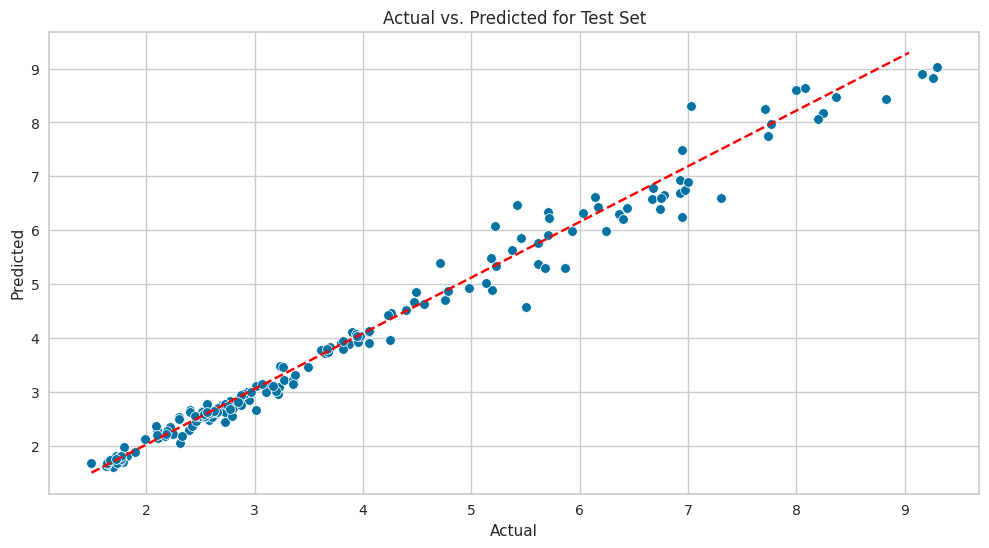

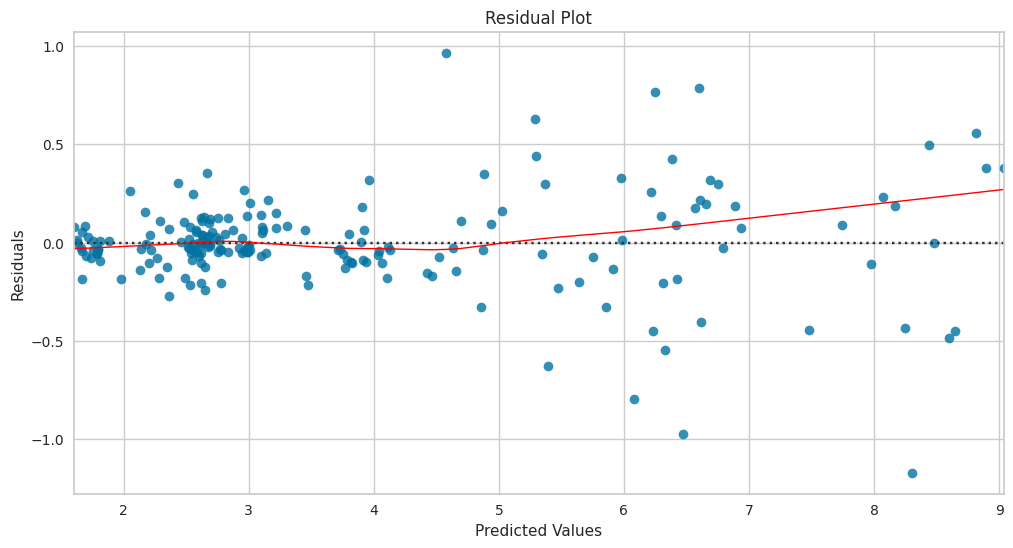

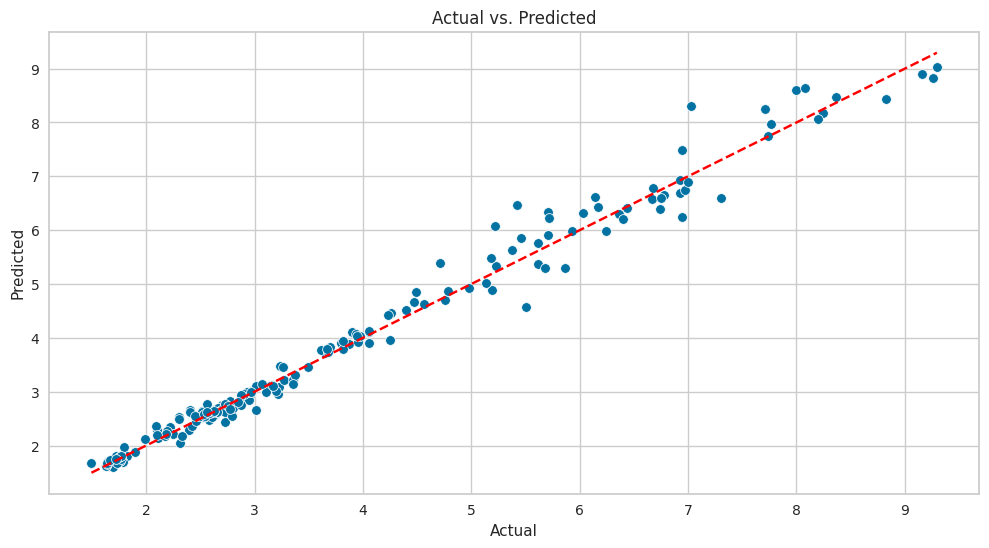

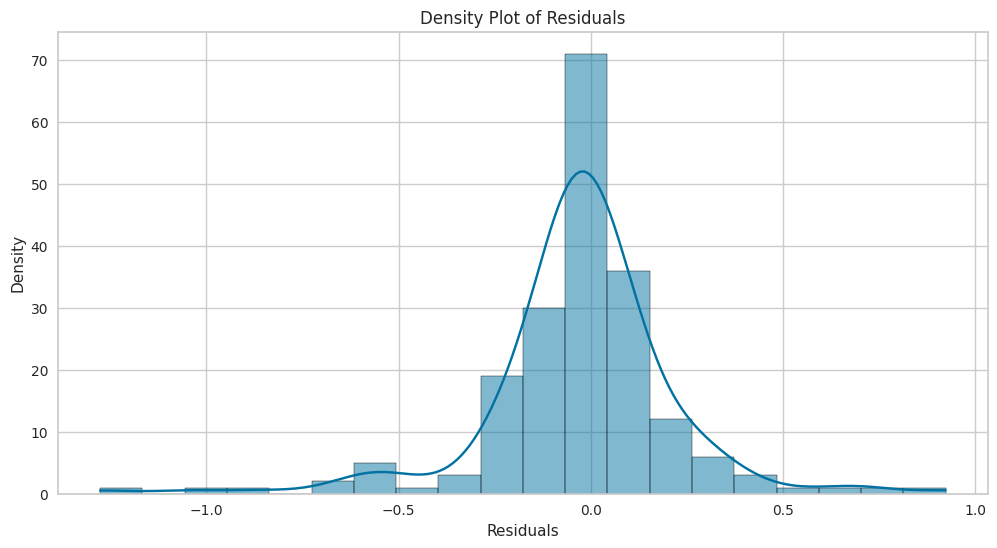

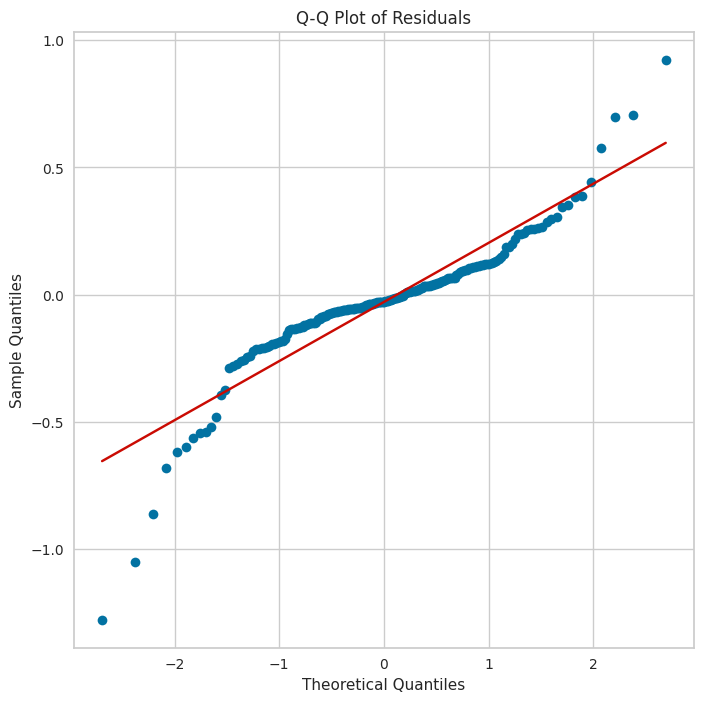

In [13]:
from yellowbrick.regressor import ResidualsPlot, PredictionError
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import scipy.stats as stats

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Flatten the arrays
y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

# Actual vs. Predicted plot for training set
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_flat, y=y_pred_flat)
plt.plot([min(y_test_flat), max(y_pred_flat)], [min(y_test_flat), max(y_test_flat)], '--', color='red')
plt.title('Actual vs. Predicted for Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('actual_vs_predicted_test_set.png')
plt.show()

# Residual plot
residuals = y_test_flat - y_pred_flat
plt.figure(figsize=(12, 6))
sns.residplot(x=y_pred_flat, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('residual_plot.png')
plt.show()

# Actual vs. Predicted plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_flat, y=y_pred_flat)
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], '--', color='red')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('actual_vs_predicted.png')
plt.show()

# Density plot of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.savefig('density_plot_of_residuals.png')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.savefig('qq_plot_of_residuals.png')
plt.show()

## Feature Importance

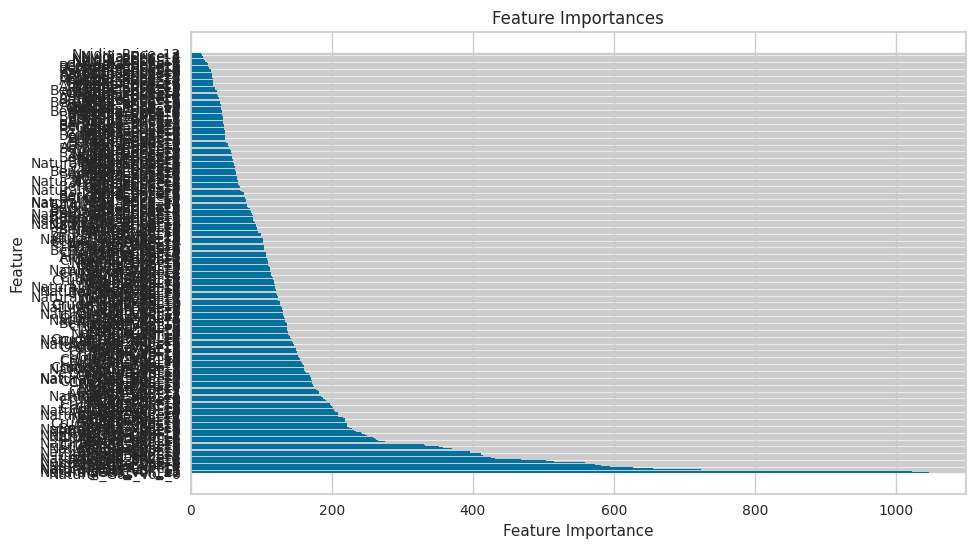

In [14]:
# Get feature importances
feature_importances = final_model.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Final Model Comparison

In [15]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.068943,0.262570,0.188617,0.983453,"[-0.08006084854589025, -0.0721568833680387, -0..."
1,LinearRegression,0.045352,0.212959,0.141142,0.989115,"[-0.05274337417864865, -0.05061002202978325, -..."
2,KNeighborsRegressor,0.284022,0.532937,0.337320,0.931831,"[-0.2634614135802469, -0.2831559681481482, -0...."
3,RandomForestRegressor,0.051737,0.227458,0.144984,0.987582,"[-0.06877181625679038, -0.055810650370370384, ..."
4,GradientBoostingRegressor,0.126377,0.355496,0.253051,0.969668,"[-0.17264465653632272, -0.1405390952736325, -0..."
5,XGBRegressor,0.060748,0.246471,0.158069,0.985420,"[-0.08308861623439583, -0.05576425586931316, -..."
6,SVR,0.137296,0.370535,0.250088,0.967047,"[-0.16761621120164696, -0.32632609783863525, -..."
7,DecisionTreeRegressor,0.079189,0.281405,0.186030,0.980994,"[-0.10260169135802466, -0.08139122839506176, -..."
8,Lasso,1.767179,1.329353,1.053598,0.575856,"[-1.5499981739122153, -2.0377549753908637, -1...."
9,ElasticNet,1.499525,1.224551,0.965960,0.640096,"[-1.3225392142516825, -1.673942215626732, -1.1..."


In [16]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)